In [1]:
import pandas as pd
import requests
from io import BytesIO
from io import StringIO
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import calendar
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt
from skforecast.model_selection import grid_search_forecaster
from datetime import datetime
from sklearn import metrics  # Para scikit-learn
from sklearn.model_selection import GridSearchCV
# from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow.keras.backend as K
import itertools
from xgboost import XGBRegressor

C:\Users\johan\anaconda3\envs\Python_3_12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# URL del repositorio en GitHub
repo_url = 'https://api.github.com/repos/Pacheco-Carvajal/GPA-Data-ElectroDunas/contents/'

# Haz una solicitud GET a la API de GitHub para obtener la lista de archivos en el directorio
response = requests.get(repo_url)
file_data = response.json()

# Filtra los archivos que contienen "datos cliente" en su nombre
desired_files = [(file['download_url'], file['name']) for file in file_data if 'DATOSCLIENTE' in file['name']]

# Crea un DataFrame combinando todos los archivos encontrados
dfs = []
for file_url, file_name in desired_files:
    response = requests.get(file_url)
    content = response.content.decode('utf-8')
    df = pd.read_csv(StringIO(content))

    # Agrega una columna "fuente" con el nombre del archivo
    df['fuente'] = file_name

    dfs.append(df)

# Concatena los DataFrames en uno solo
result_df = pd.concat(dfs, ignore_index=True)

In [3]:
# URL cruda del archivo en GitHub
url = "https://github.com/Pacheco-Carvajal/GPA-Data-ElectroDunas/raw/main/sector_economico_clientes.xlsx"

# Cargar el archivo Excel en un DataFrame
sectores = pd.read_excel(url)

# Mostrar las primeras filas del DataFrame
sectores.head()

,Cliente:,Sector Económico:
0,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,Cliente 2,Elaboración de cacao y chocolate y de producto...
2,Cliente 3,Elaboración de cacao y chocolate y de producto...
3,Cliente 4,Elaboración de cacao y chocolate y de producto...
4,Cliente 5,Elaboración de cacao y chocolate y de producto...


In [4]:
# Extraer los números de la columna 'fuente'
result_df['fuente'] = result_df['fuente'].str.extract('(\d+)')

# Concatenar 'Cliente' con los números extraídos
result_df['fuente'] = 'Cliente ' + result_df['fuente']

result_df.head()

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\johan\AppData\Local\Temp\ipykernel_1824\2501991270.py:2: SyntaxWarning: invalid escape sequence '\d'
  result_df['fuente'] = result_df['fuente'].str.extract('(\d+)')


,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,fuente
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1


In [5]:
result_df = result_df.rename(columns={'fuente': 'Cliente'})
sectores = sectores.rename(columns={'Cliente:': 'Cliente'})
sectores['Cliente'] = sectores['Cliente'].str.strip()

In [7]:
result_df = pd.merge(result_df, sectores[['Cliente', 'Sector Económico:']], on='Cliente', how='left')
result_df.head()

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente,Sector Económico:
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1,Elaboración de cacao y chocolate y de producto...
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1,Elaboración de cacao y chocolate y de producto...
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1,Elaboración de cacao y chocolate y de producto...
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1,Elaboración de cacao y chocolate y de producto...


In [8]:
result_df = result_df.rename(columns={'Sector Económico:': 'Sector Económico'})
result_df['Fecha'] = pd.to_datetime(result_df['Fecha'])
#Impuación a cero
result_df['Active_energy'] = result_df['Active_energy'].apply(lambda x: 0 if x < 0 else x)

In [48]:
# Asegúrate de que 'Fecha' está en formato de fecha si no está convertido aún
result_df['Fecha'] = pd.to_datetime(result_df['Fecha'])
# Calcula la media por cliente
media_por_cliente = result_df.groupby('Cliente')['Active_energy'].mean()
# Imputa los valores cero con la media correspond]iente por cliente
result_df['Active_energy_ajustada'] = result_df.apply(lambda row: media_por_cliente[row['Cliente']] if row['Active_energy'] == 0 else row['Active_energy'], axis=1)
result_df

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente,Sector Económico,Active_energy_ajustada
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1,Elaboración de cacao y chocolate y de producto...,0.357841
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1,Elaboración de cacao y chocolate y de producto...,0.372264
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1,Elaboración de cacao y chocolate y de producto...,1.044687
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1,Elaboración de cacao y chocolate y de producto...,0.566425
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1,Elaboración de cacao y chocolate y de producto...,1.080556
...,...,...,...,...,...,...,...,...
463420,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372,Cliente 9,Cultivo de Árboles Frutales y Nueces,0.231000
463421,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989,Cliente 9,Cultivo de Árboles Frutales y Nueces,0.041937
463422,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378,Cliente 9,Cultivo de Árboles Frutales y Nueces,0.231000
463423,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710,Cliente 9,Cultivo de Árboles Frutales y Nueces,0.150296


In [10]:
# Cargar la configuración de los mejores modelos
best_models_cfgs = pd.read_excel("best_models.xlsx")
best_models_cfgs.head()

,Cliente,Frecuencia,Rezago,Modelo,Hiperparametros,Imputado,Incluye_reactiva,MSE,MAE,RMSE,MAPE,R2,Len_train,Len_test,Len_total
0,1,12H,15,XGB,"(100, 5, 0.1, 0)",NO,SI,2.706898,0.878964,1.645265,5.960438,0.991517,1168,293,1461
1,2,12H,30,XGB,"(100, 5, 0.1, 0.1)",SI,SI,1.224235,0.869559,1.106452,2.911840,0.995850,1144,287,1431
2,3,12H,15,XGB,"(500, 3, 0.01, 0.1)",SI,SI,2.835736,1.190024,1.683964,4.563932,0.989172,1168,293,1461
3,4,24H,15,LSTM,"(100, 'tanh', 25)",NO,NO,3.456521,0.942456,1.859172,6.225067,0.877059,590,133,738
4,5,24H,15,LSTM,"(100, 'tanh', 25)",NO,NO,145.561917,9.437617,12.064904,10.044523,-0.037633,590,133,738


In [11]:
# Filtramos por los LSTM que es de los que se encarga este NB
best_models_cfgs = best_models_cfgs[best_models_cfgs['Modelo']=='LSTM']
best_models_cfgs.head()

,Cliente,Frecuencia,Rezago,Modelo,Hiperparametros,Imputado,Incluye_reactiva,MSE,MAE,RMSE,MAPE,R2,Len_train,Len_test,Len_total
3,4,24H,15,LSTM,"(100, 'tanh', 25)",NO,NO,3.456521,0.942456,1.859172,6.225067,0.877059,590,133,738
4,5,24H,15,LSTM,"(100, 'tanh', 25)",NO,NO,145.561917,9.437617,12.064904,10.044523,-0.037633,590,133,738
5,6,24H,30,LSTM,"(100, 'tanh', 25)",NO,NO,2.188405,1.218548,1.479326,9.596906,0.758800,590,118,738
6,7,48H,30,LSTM,"(100, 'tanh', 25)",NO,NO,1181.262072,13.827492,34.369493,10.317317,-0.051117,295,44,369
7,8,48H,30,LSTM,"(100, 'tanh', 25)",NO,NO,33.923690,4.506628,5.824405,8.381718,-0.414433,295,44,369


In [12]:
best_models_cfgs['Imputado'].value_counts()

# Calcula la media por cliente
#media_por_cliente = result_df.groupby('Cliente')['Active_energy'].mean()

# Imputa los valores cero con la media correspondiente por cliente
#result_df['Active_energy_ajustada'] = result_df.apply(lambda row: media_por_cliente[row['Cliente']] if row['Active_energy'] == 0 else row['Active_energy'], axis=1)

Imputado
NO    14
Name: count, dtype: int64

In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return K.mean(K.abs((y_true - y_pred) / K.clip(K.abs(y_true), K.epsilon(), None))) * 100

In [14]:
# Definir función para evaluación métrica
def evaluacion_metrica(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Calcular métricas
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    # Devolver métricas como un diccionario
    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    }

In [21]:
import ast

resultados_totales = []  # Lista para almacenar los resultados de todos los clientes
predictions = []

for row in best_models_cfgs.iterrows():
    params = ast.literal_eval(row[1]['Hiperparametros'])
    numero_cliente = row[1]['Cliente']
    frecuencia = row[1]['Frecuencia'].lower()
    rezago = row[1]['Rezago']
    neuronas = params[0]
    f_activacion = params[1]
    num_epochs = params[2]
    
    
    cliente = 'Cliente ' + str(numero_cliente)
    cliente_df = result_df[result_df['Cliente'] == cliente].copy()
    
    # Ordenar los datos por fecha de manera ascendente
    cliente_df = cliente_df.sort_values(by='Fecha')
    
    # Obtener la columna de 'Active_energy' y establecer 'Fecha' como índice
    data_completa = cliente_df[['Fecha', 'Active_energy']]
    data_completa.set_index('Fecha', inplace=True)
    
    # Seleccionar el 95% de los datos
    # data_completa = data_completa.iloc[:int(0.9 * len(data_completa))]
       
    # Resample los datos a la frecuencia especificada y sumar la energía activa
    data_completa_diaria = data_completa.resample(frecuencia).sum()

    # Reiniciar el índice para que 'Fecha' sea una columna nuevamente
    data_completa_diaria.reset_index(inplace=True)
    
    # Establecer el índice en 'Fecha' y la frecuencia
    data_completa_diaria.set_index('Fecha', inplace=True)
    data_completa_diaria.index.freq = frecuencia

    # Eliminar filas con valores NaN
    data_completa_diaria.dropna(inplace=True)
    
    dataindex= pd.to_datetime(data_completa_diaria.index)
    dt2= data_completa_diaria.to_numpy()
    close_data = dt2.reshape((-1,1))

    split_percent = 0.90
    split = int(split_percent*len(close_data))

    #Aplicamos dicha proporción a la definición de la parte de entrenamiento y de prueba.
    close_train = close_data[:split]
    close_test = close_data[split:]

    date_train = dataindex[:split]
    date_test = dataindex[split:]
    
    train_generator = TimeseriesGenerator(close_train, close_train, length=rezago, batch_size=10) 
    test_generator = TimeseriesGenerator(close_test, close_test, length=rezago, batch_size=1)

    model = Sequential()
    model.add(
        LSTM(neuronas,  ## de nodos, dependerá de su poder de cómputo.
             activation=f_activacion, #relu #función de activación.
             input_shape=(rezago,1))   ##la longitud de la secuencia
    )
    model.add(Dense(1))  #capa de salida de predicción
    model.compile(optimizer='adam', loss=mean_absolute_percentage_error)

    # model.fit_generator(train_generator, epochs=num_epochs, verbose=0)
    # model.fit(train_generator, epochs=num_epochs, verbose=0)
    history = model.fit(train_generator, epochs=num_epochs, verbose=0)

    #Predicción en el set de prueba:
    prediction = model.predict(test_generator)
                
    #El siguiente se emplea para pasar el tipo de datos de tensores a datos de una dimensión, aplicamos la función reshape.
    close_train = close_train.reshape((-1))
    close_test = close_test.reshape((-1))
    prediction = prediction.reshape((-1))
    selected_data = close_test[rezago:]

    # Evaluar métricas de rendimiento
    metricas = evaluacion_metrica(selected_data, prediction)

    # Almacenar resultados en la lista
    resultados_totales.append({
        'Cliente': cliente,
        'Frecuencia': frecuencia,
        'Rezago': rezago,
        'Modelo': 'LSTM',
        'Hiperparametros': params,
        **metricas,  # Desempaquetar métricas como un diccionario
        'Len_train': len(close_train),
        'Len_test': len(prediction),
        'Len_total': len(close_data)
    })
    
    predictions.append({
        'cliente': cliente,
        'prediction': prediction,
        'rezago': rezago,
        'date_test': date_test,
        'selected_data': selected_data,
        'close_data': close_data,
        'dataindex': dataindex
    })

# Convertir la lista de resultados en un DataFrame
resultados_df = pd.DataFrame(resultados_totales)

# Mostrar resultados
resultados_df

11/11 [==============================] - 0s 2ms/step


,Cliente,Frecuencia,Rezago,Modelo,Hiperparametros,MSE,MAE,RMSE,MAPE,R2,Len_train,Len_test,Len_total
0,Cliente 4,24h,15,LSTM,"(100, tanh, 25)",69.904270,5.565258,8.360877,95.380244,-0.241476,738,68,821
1,Cliente 5,24h,15,LSTM,"(100, tanh, 25)",301.715402,10.859004,17.369957,34.552951,-0.021022,738,68,821
2,Cliente 6,24h,30,LSTM,"(100, tanh, 25)",6.054914,1.593997,2.460673,43.105341,0.464998,738,53,821
3,Cliente 7,48h,30,LSTM,"(100, tanh, 25)",485.036991,11.076670,22.023555,298.869199,-0.006791,369,12,411
4,Cliente 8,48h,30,LSTM,"(100, tanh, 25)",286.455699,8.091741,16.925002,309.274441,-0.090825,369,12,411
5,Cliente 10,48h,15,LSTM,"(100, tanh, 25)",1089.563456,31.474654,33.008536,142.848584,-1.576465,369,27,411
6,Cliente 11,24h,30,LSTM,"(100, tanh, 25)",3.625779,1.376003,1.904148,12.249880,-0.232439,525,29,584
7,Cliente 13,24h,15,LSTM,"(100, tanh, 25)",11.130681,1.951227,3.336267,9.592159,-0.066855,525,44,584
8,Cliente 14,24h,15,LSTM,"(100, tanh, 25)",0.786552,0.672640,0.886878,13.133364,-0.474730,525,44,584
9,Cliente 15,24h,15,LSTM,"(100, tanh, 25)",4.755864,1.619446,2.180794,13.644072,-0.249711,525,44,584


Cliente 4 - Cantidad pred 68


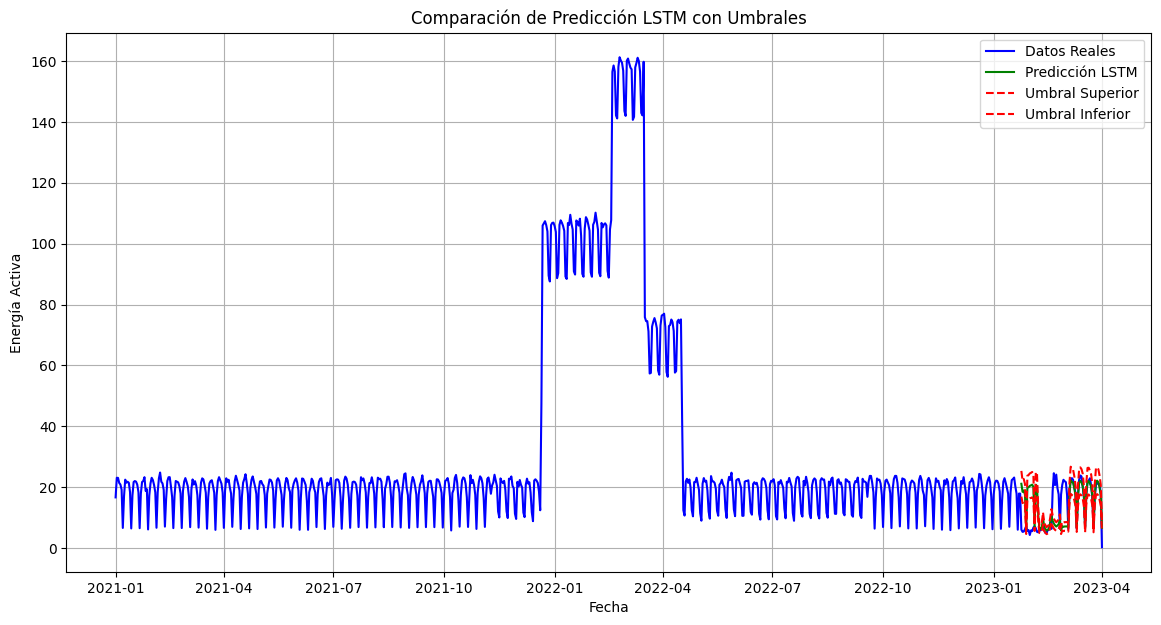

*************************************************
Cliente 5 - Cantidad pred 68


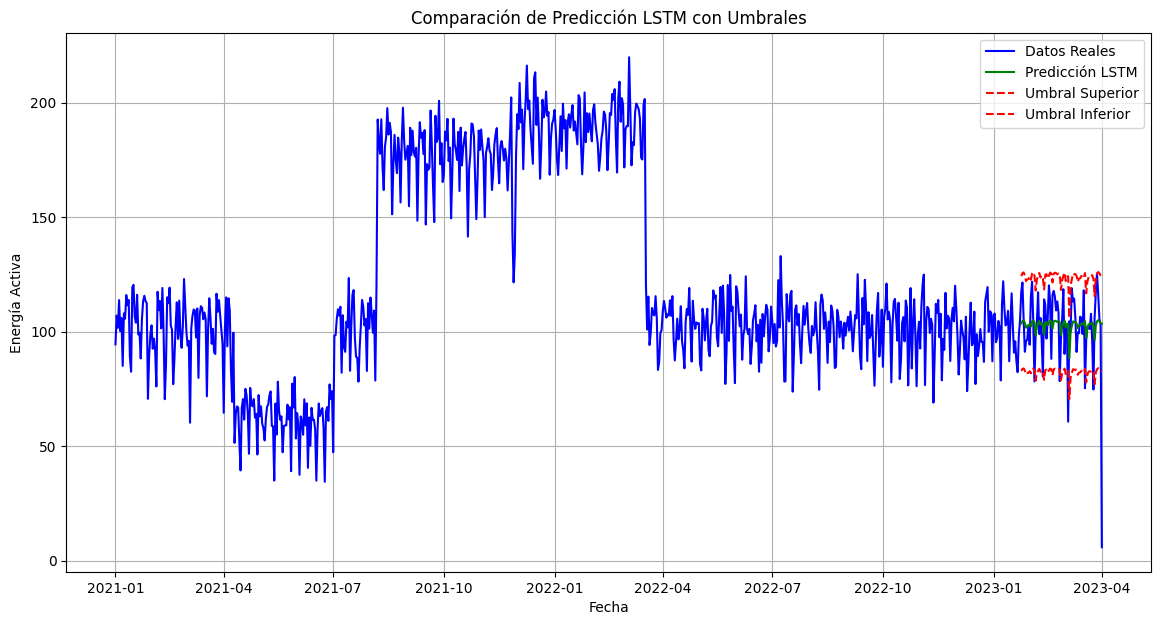

*************************************************
Cliente 6 - Cantidad pred 53


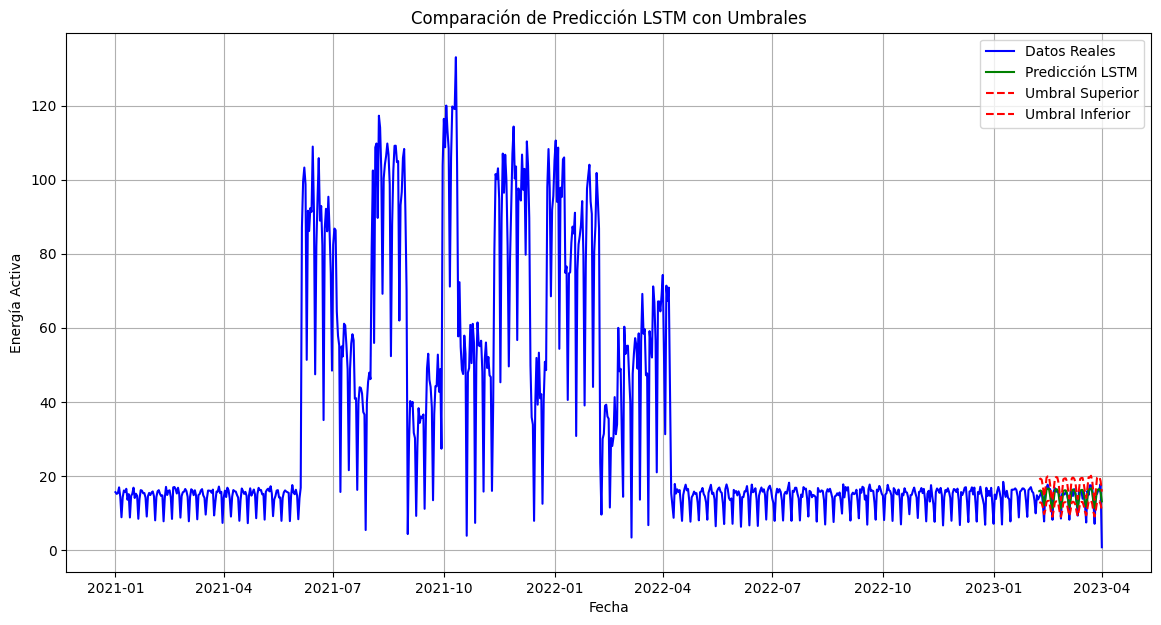

*************************************************
Cliente 7 - Cantidad pred 12


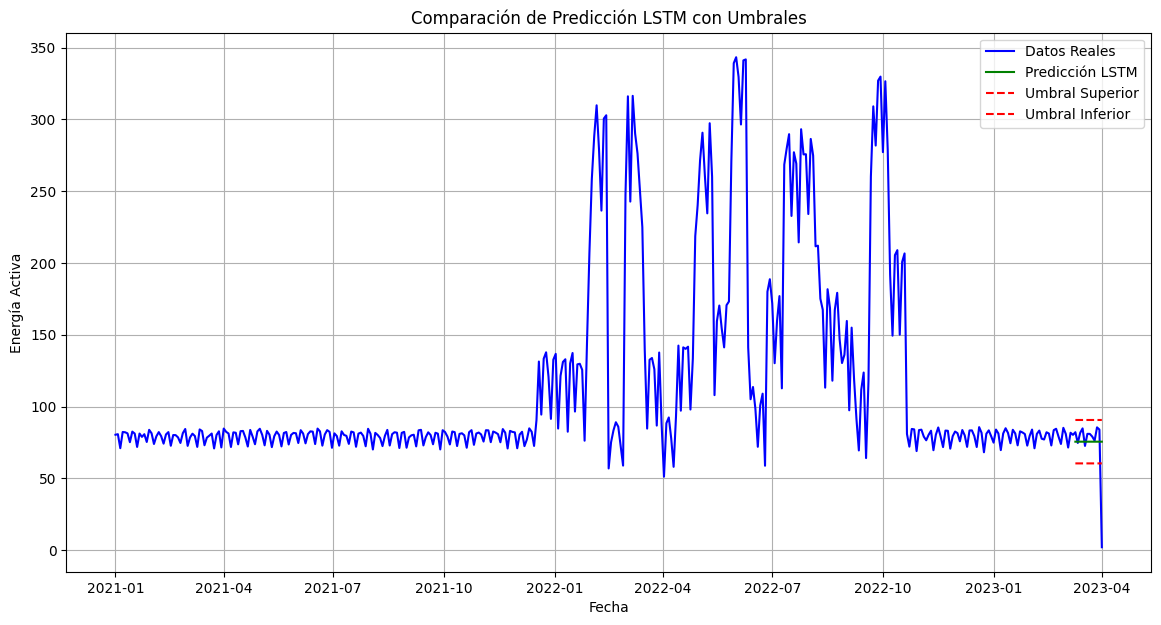

*************************************************
Cliente 8 - Cantidad pred 12


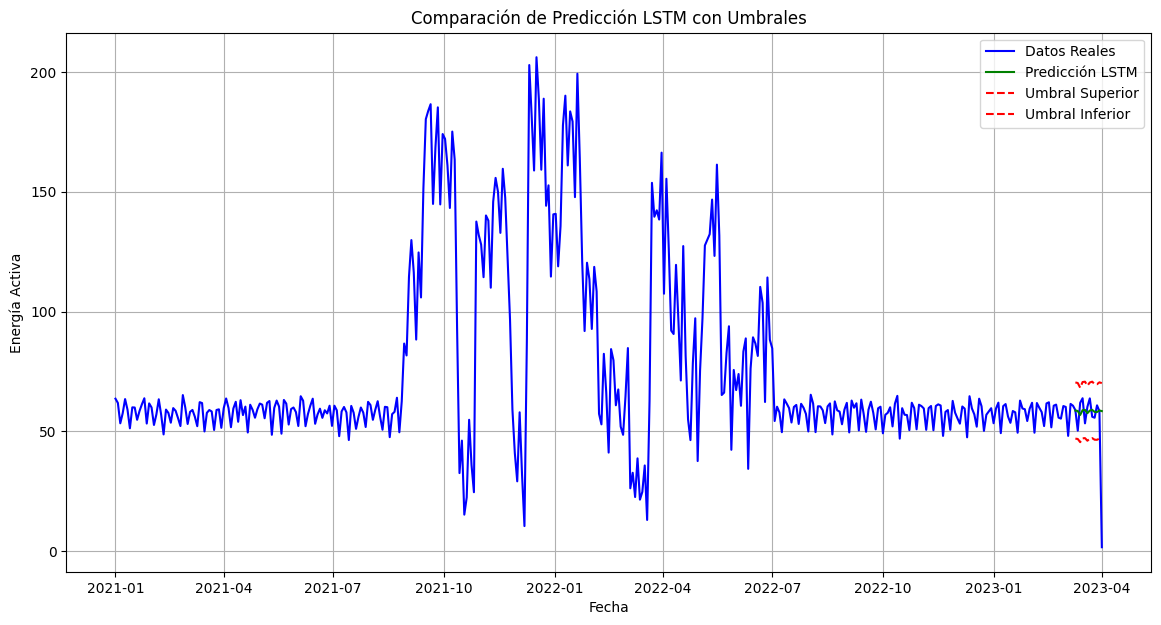

*************************************************
Cliente 10 - Cantidad pred 27


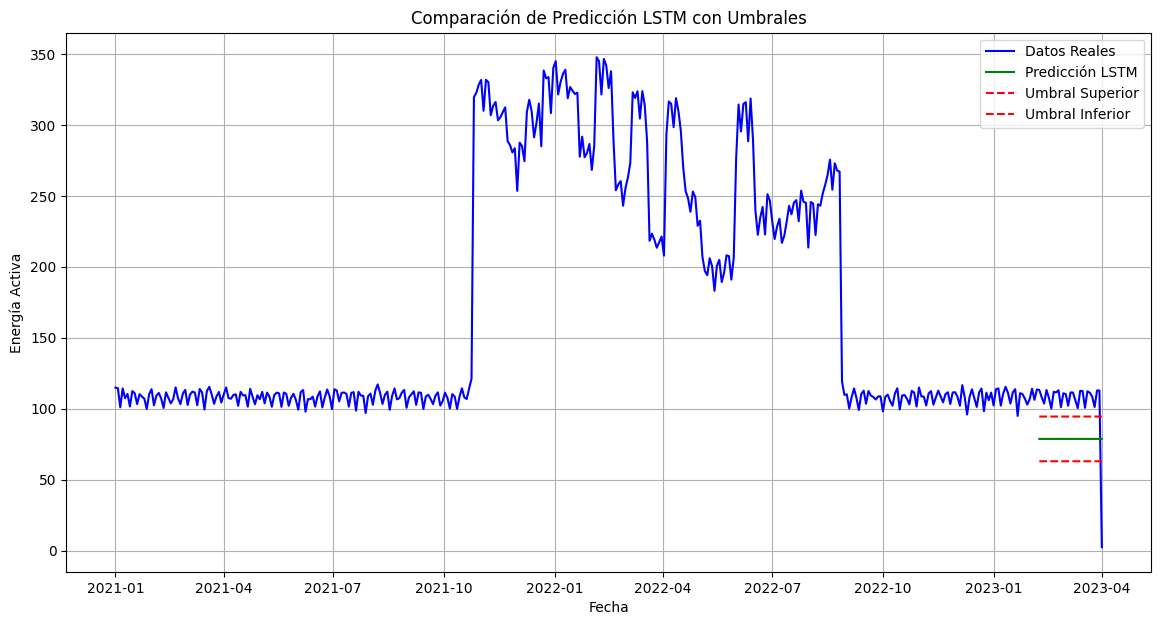

*************************************************
Cliente 11 - Cantidad pred 29


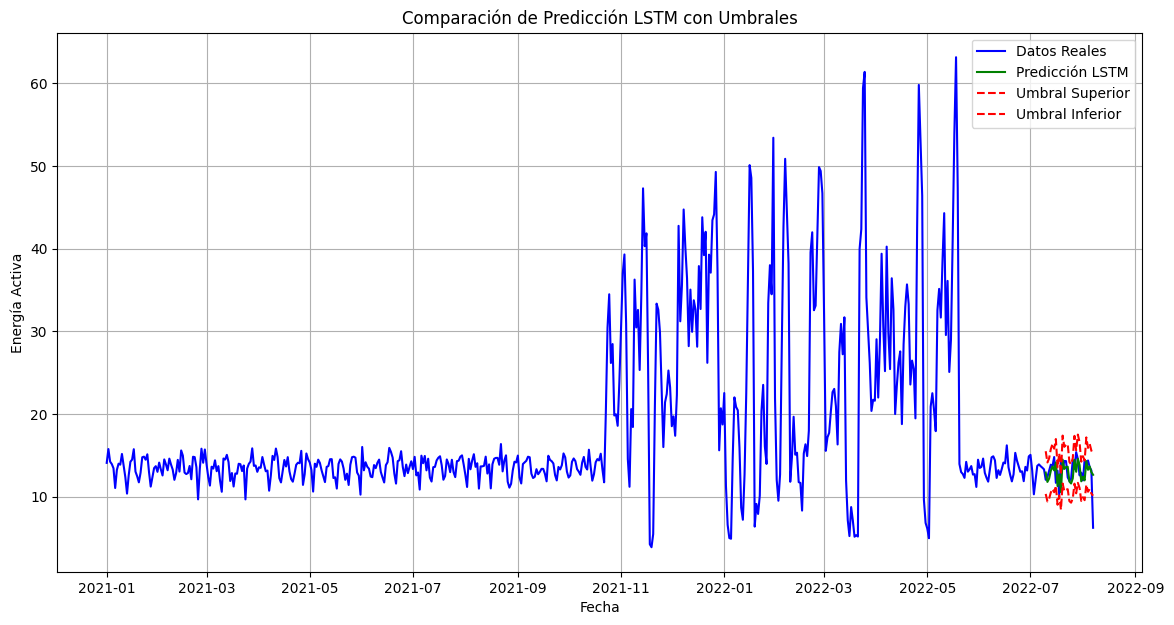

*************************************************
Cliente 13 - Cantidad pred 44


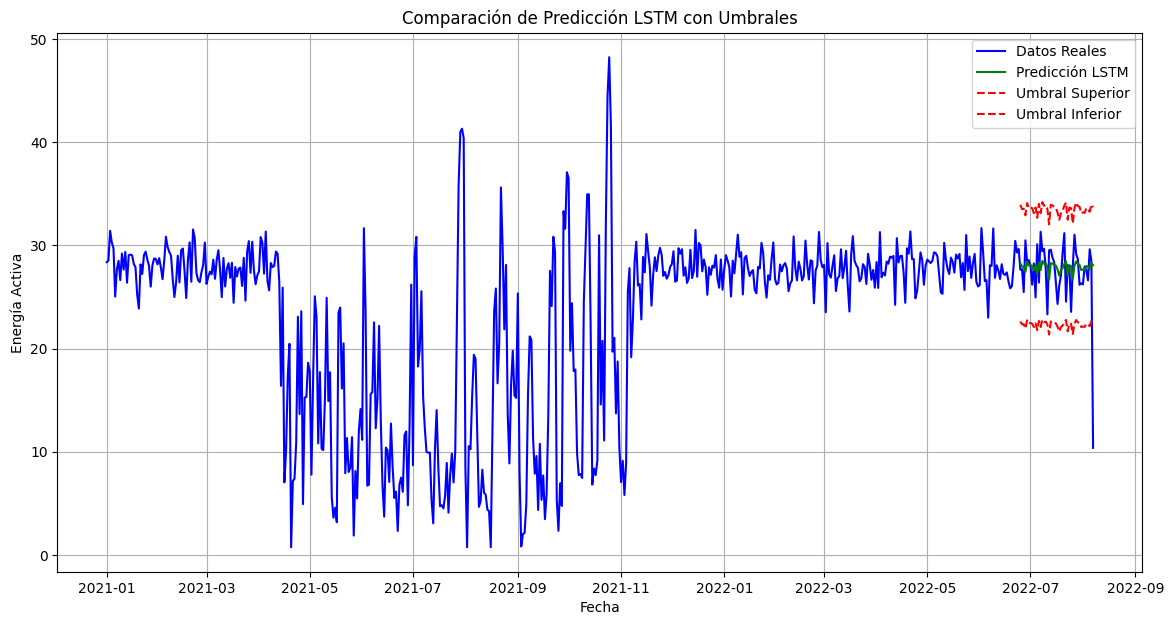

*************************************************
Cliente 14 - Cantidad pred 44


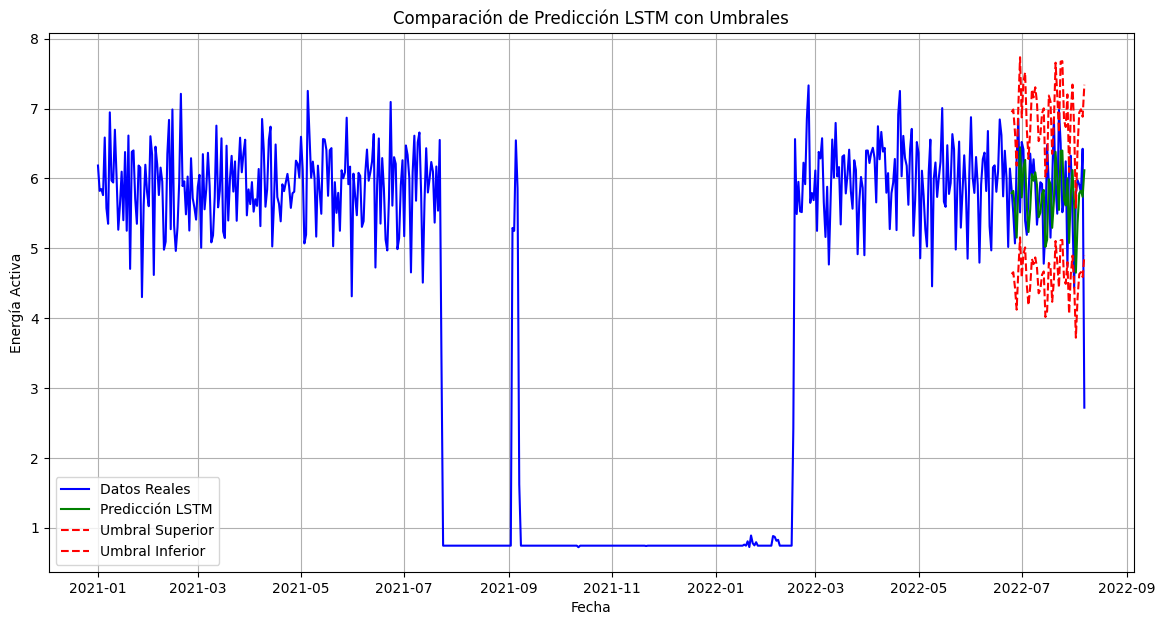

*************************************************
Cliente 15 - Cantidad pred 44


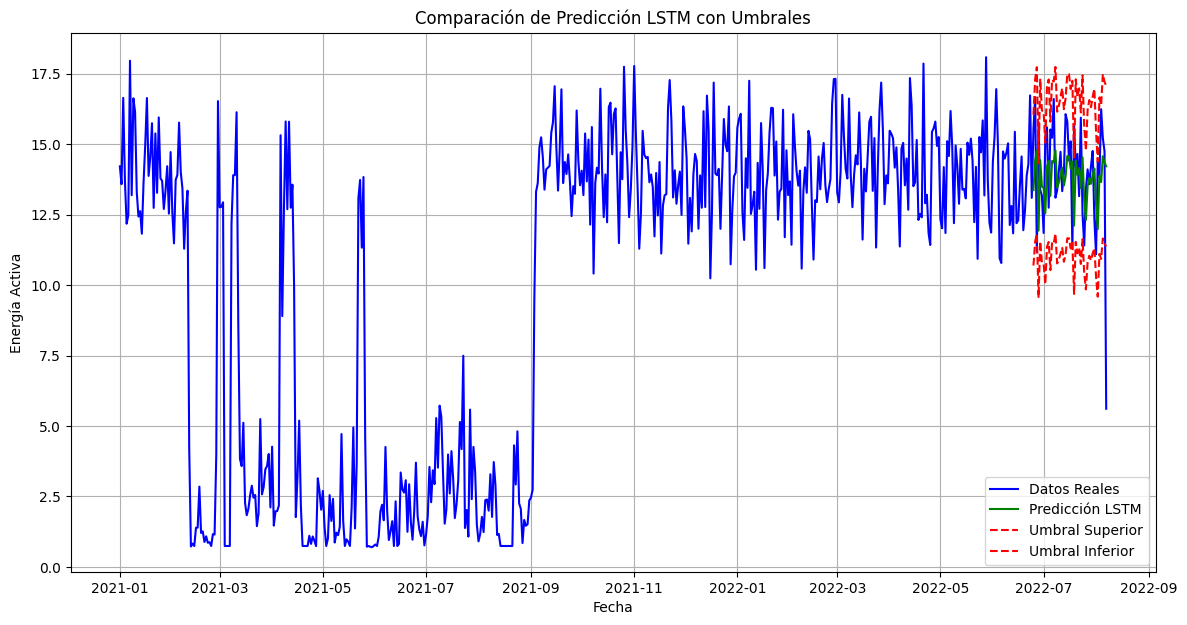

*************************************************
Cliente 16 - Cantidad pred 26


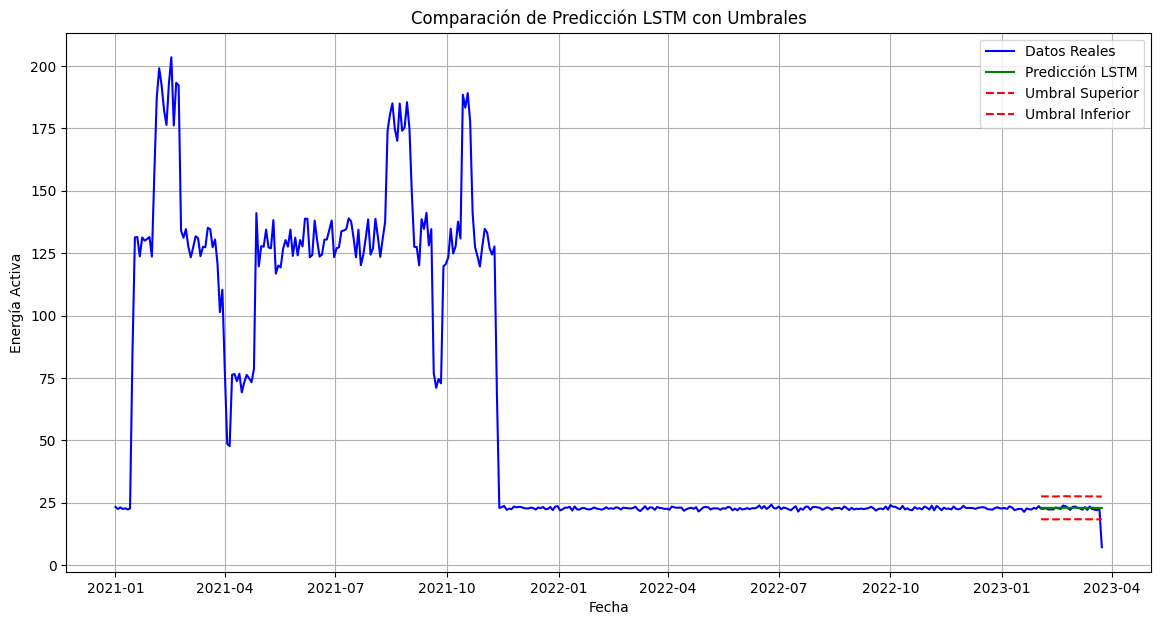

*************************************************
Cliente 17 - Cantidad pred 26


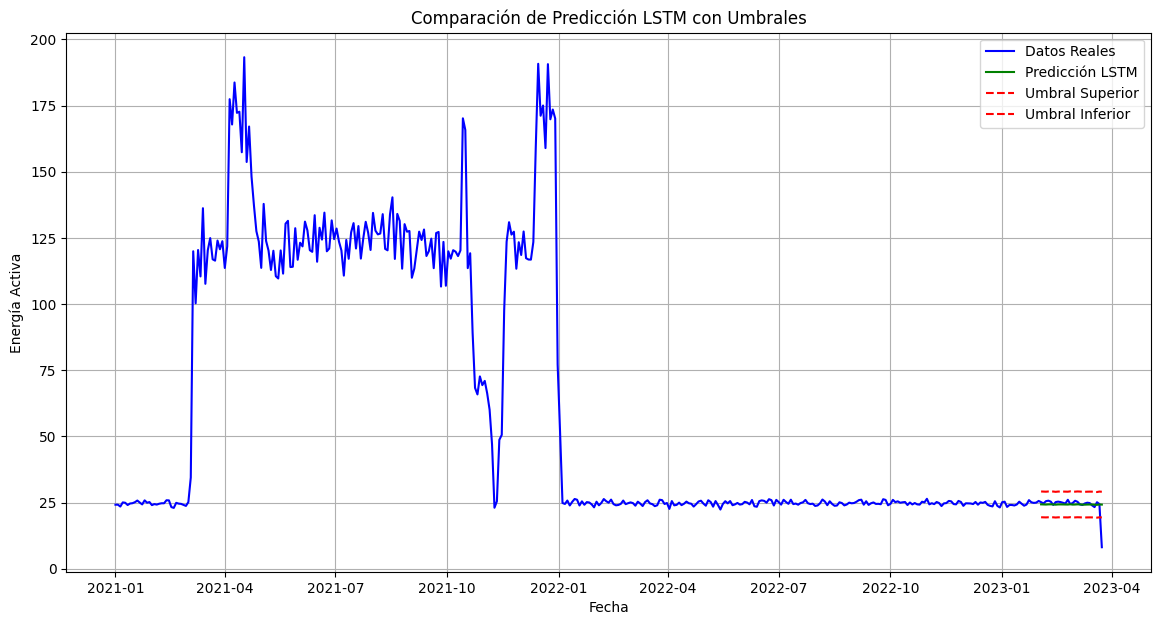

*************************************************
Cliente 18 - Cantidad pred 26


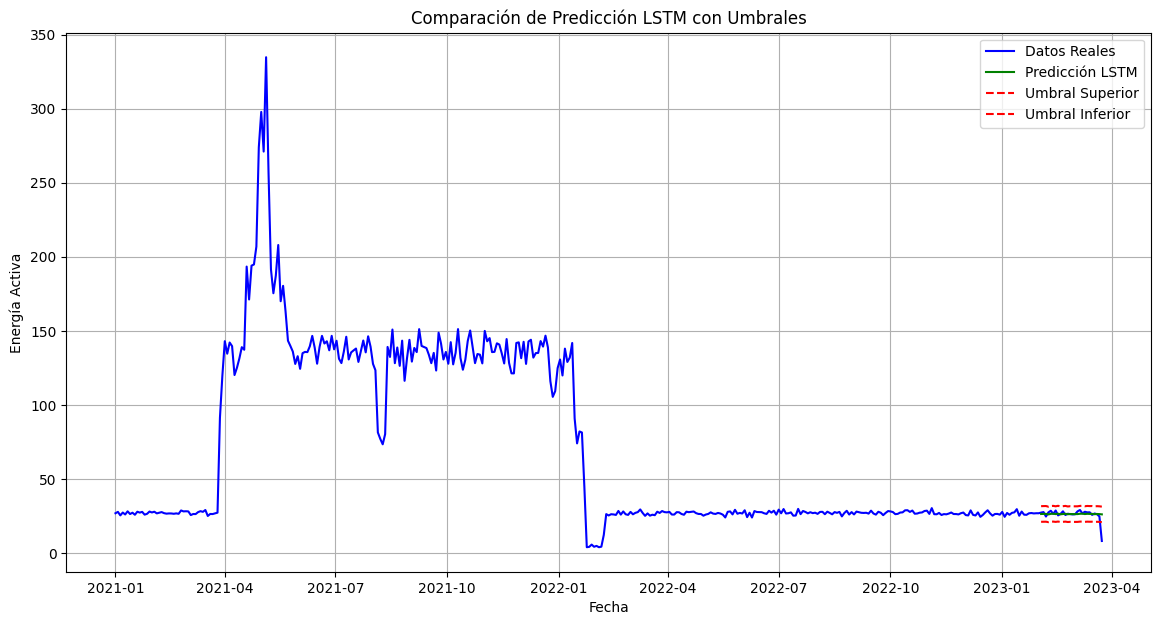

*************************************************
Cliente 19 - Cantidad pred 11


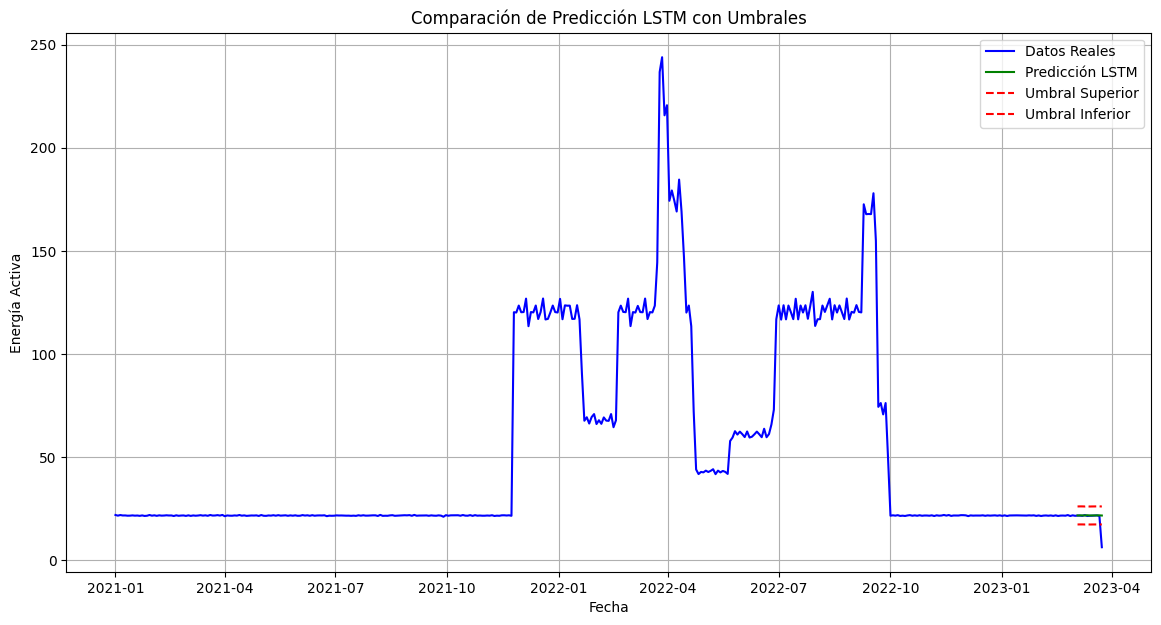

*************************************************


In [23]:
for pred_obj in predictions:
    
    prediction = pred_obj['prediction']
    cliente = pred_obj['cliente']
    rezago = pred_obj['rezago']
    date_test = pred_obj['date_test']
    selected_data = pred_obj['selected_data']
    close_data = pred_obj['close_data']
    dataindex = pred_obj['dataindex']
    
    print(cliente, "- Cantidad pred",len(prediction))
        
    # Definir un porcentaje para los umbrales
    porcentaje_umbral = 0.2  # 10%

    # Calcular umbrales
    umbral_superior = prediction * (1 + porcentaje_umbral)
    umbral_inferior = prediction * (1 - porcentaje_umbral)
    
    # Asegurarse de tener datos de fechas para el eje X
    date_test_trimmed = date_test[rezago:]  # Recortar las fechas para coincidir con el tamaño del array ajustado de prueba

    plt.figure(figsize=(14, 7))
    plt.plot(dataindex, close_data, label='Datos Reales', color='blue') 
    #plt.plot(date_test_trimmed, selected_data, label='Datos Reales', color='blue')
    plt.plot(date_test_trimmed, prediction, label='Predicción LSTM', color='green')
    plt.plot(date_test_trimmed, umbral_superior, label='Umbral Superior', linestyle='--', color='red')
    plt.plot(date_test_trimmed, umbral_inferior, label='Umbral Inferior', linestyle='--', color='red')
    plt.title('Comparación de Predicción LSTM con Umbrales')
    plt.xlabel('Fecha')
    plt.ylabel('Energía Activa')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Convertir las predicciones y los intervalos de confianza en DataFrames con el mismo índice que test_feature
    real_df = pd.DataFrame(close_data, index=dataindex, columns=['Active_energy'])
    fcst_df = pd.DataFrame(prediction, index=date_test_trimmed, columns=['Predictions'])
    lower_bound_df = pd.DataFrame(umbral_inferior, index=date_test_trimmed, columns=['Lower_Bound'])
    upper_bound_df = pd.DataFrame(umbral_superior, index=date_test_trimmed, columns=['Upper_Bound'])

    # Combinar test_feature, fcst_df, lower_bound_df y upper_bound_df en un solo DataFrame
    combined_df = pd.concat([real_df, fcst_df, lower_bound_df, upper_bound_df], axis=1)
    combined_df['anomalias'] = ((combined_df['Active_energy'] > combined_df['Upper_Bound']) |
                                (combined_df['Active_energy'] < combined_df['Lower_Bound']))

    # Imprimir el DataFrame resultante
    # print(combined_df.head(5))
    
    # Guardar el archivo.
    combined_df.to_excel('dashboard/data/'+cliente+'.xlsx')

    print('*************************************************')
    

## Modelos XGB

In [40]:
# Cargar la configuración de los mejores modelos
best_models_cfgs = pd.read_excel("best_models.xlsx")
best_models_cfgs.head()

,Cliente,Frecuencia,Rezago,Modelo,Hiperparametros,Imputado,Incluye_reactiva,MSE,MAE,RMSE,MAPE,R2,Len_train,Len_test,Len_total
0,1,12H,15,XGB,"(100, 3, 0.1, 0.1)",SI,SI,1.031712,0.665366,1.015732,6.385722,0.950245,1168,293,1461
1,2,12H,15,XGB,"(100, 7, 0.05, 0)",SI,SI,0.917383,0.751974,0.957801,2.884171,0.959232,1168,293,1461
2,3,12H,30,XGB,"(500, 5, 0.01, 0.1)",SI,SI,1.329210,0.901958,1.152914,4.497846,0.942780,1156,290,1446
3,4,24H,15,LSTM,"(100, 'tanh', 25)",NO,NO,3.456521,0.942456,1.859172,6.225067,0.877059,590,133,738
4,5,24H,15,LSTM,"(100, 'tanh', 25)",NO,NO,145.561917,9.437617,12.064904,10.044523,-0.037633,590,133,738


In [41]:
# Filtramos por los XGB que es de los que se encarga este NB
best_models_cfgs = best_models_cfgs[best_models_cfgs['Modelo']=='XGB']
best_models_cfgs.head()

,Cliente,Frecuencia,Rezago,Modelo,Hiperparametros,Imputado,Incluye_reactiva,MSE,MAE,RMSE,MAPE,R2,Len_train,Len_test,Len_total
0,1,12H,15,XGB,"(100, 3, 0.1, 0.1)",SI,SI,1.031712,0.665366,1.015732,6.385722,0.950245,1168,293,1461
1,2,12H,15,XGB,"(100, 7, 0.05, 0)",SI,SI,0.917383,0.751974,0.957801,2.884171,0.959232,1168,293,1461
2,3,12H,30,XGB,"(500, 5, 0.01, 0.1)",SI,SI,1.329210,0.901958,1.152914,4.497846,0.942780,1156,290,1446
8,9,8H,15,XGB,"(500, 3, 0.1, 0.1)",SI,SI,3.760233,1.297924,1.939132,12.177944,0.902063,1759,440,2199
11,12,8H,30,XGB,"(100, 5, 0.1, 0.2)",SI,SI,1.091392,0.788409,1.044697,1.618113,-0.230823,1004,251,1255


In [42]:
best_models_cfgs['Imputado'].value_counts()

Imputado
SI    16
Name: count, dtype: int64

In [54]:
import ast

resultados_totales = []  # Lista para almacenar los resultados de todos los clientes
predictions = []

for row in best_models_cfgs.iterrows():
    params = ast.literal_eval(row[1]['Hiperparametros'])
    numero_cliente = row[1]['Cliente']
    frecuencia = row[1]['Frecuencia'].lower()
    rezagos = row[1]['Rezago']
    n_estimators = params[0]
    max_depth = params[1]
    learning_rate = params[2]
    gamma = params[2]
    
    cliente = 'Cliente ' + str(numero_cliente)
    cliente_df = result_df[result_df['Cliente'] == cliente].copy()
    
    # Ordenar los datos por fecha de manera ascendente
    cliente_df = cliente_df.sort_values(by='Fecha')
    
    # Obtener la columna de 'Active_energy' y establecer 'Fecha' como índice
    data_completa = cliente_df[['Fecha','Active_energy_ajustada', 'Active_energy','Reactive_energy']]
    data_completa.set_index('Fecha', inplace=True)
        
    # Resample los datos a la frecuencia especificada y sumar la energía activa
    data_completa_1 = data_completa.resample(frecuencia).sum()
    data_completa_1 = data_completa_1[['Active_energy']]
    
    data_completa_diaria = data_completa[['Active_energy_ajustada','Reactive_energy']]
    data_completa_diaria = data_completa_diaria.resample(frecuencia).sum()
    
    # Reiniciar el índice para que 'Fecha' sea una columna nuevamente
    data_completa_diaria.reset_index(inplace=True)
    
    # Agregar columnas de mes y hora
    data_completa_diaria['Month'] = data_completa_diaria['Fecha'].dt.month
    data_completa_diaria['Hour'] = data_completa_diaria['Fecha'].dt.hour
    
    # Establecer el índice en 'Fecha' y la frecuencia
    data_completa_diaria.set_index('Fecha', inplace=True)
    data_completa_diaria.index.freq = frecuencia
    
    for rezago in range(1, rezagos+1):#Rezagos de la diferencia:
        # Crear columnas de rezagos para los datos
        data_completa_diaria[f'L{rezago}'] = data_completa_diaria['Active_energy_ajustada'].shift(rezago)
    
    # Eliminar filas con valores NaN
    data_completa_diaria.dropna(inplace=True)
    
    # Definir variables predictoras (X) y variable objetivo (Y)
    X = data_completa_diaria.iloc[:, 1:]
    Y = data_completa_diaria.iloc[:, 0]
    
    # Dividir datos en entrenamiento y prueba (90% entrenamiento, 10% prueba)
    split_percent = 0.90
    split = int(split_percent*len(Y))
    
    #Aplicamos dicha proporción a la definición de la parte de entrenamiento y de prueba.
    X_train = X[:split]
    X_test = X[split:]
    
    Y_train = Y[:split]
    Y_test = Y[split:]
    
    modelo = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, gamma=gamma, n_jobs=-1)
    modelo.fit(X_train, Y_train)
    
    # Hacer predicciones
    prediction = modelo.predict(X_test)
    
    # Evaluar métricas de rendimiento
    metricas = evaluacion_metrica(Y_test, prediction)
        
    # Almacenar resultados en la lista
    resultados_totales.append({
        'Cliente': cliente,
        'Frecuencia': frecuencia,
        'Rezago': rezagos,
        'Modelo': 'XGB',
        'Hiperparametros': params,
        **metricas,  # Desempaquetar métricas como un diccionario
        'Len_train': len(X_train),
        'Len_test': len(X_test),
        'Len_total': len(data_completa_diaria)
    })
    
    predictions.append({
        'cliente': cliente,
        'prediction': prediction,
        'rezago': rezagos,
        'data_completa': data_completa_1
    })

# Convertir la lista de resultados en un DataFrame
resultados_df = pd.DataFrame(resultados_totales)

# Mostrar resultados
resultados_df

,Cliente,Frecuencia,Rezago,Modelo,Hiperparametros,MSE,MAE,RMSE,MAPE,R2,Len_train,Len_test,Len_total
0,Cliente 1,12h,15,XGB,"(100, 3, 0.1, 0.1)",1.020635,0.708076,1.010265,8.185798,0.951191,1463,163,1626
1,Cliente 2,12h,15,XGB,"(100, 7, 0.05, 0)",23.606752,2.491162,4.858678,28.584280,0.581139,1463,163,1626
2,Cliente 3,12h,30,XGB,"(500, 5, 0.01, 0.1)",12.397504,2.151028,3.521009,25.755955,0.702310,1449,162,1611
3,Cliente 9,8h,15,XGB,"(500, 3, 0.1, 0.1)",0.105580,0.231949,0.324931,18.749389,0.681482,2201,245,2446
4,Cliente 12,8h,30,XGB,"(100, 5, 0.1, 0.2)",0.840856,0.733857,0.916982,12.682657,-0.057775,1257,140,1397
5,Cliente 20,8h,30,XGB,"(500, 5, 0.1, 0.2)",0.026368,0.070960,0.162383,2.123791,0.935159,2167,241,2408
6,Cliente 21,12h,15,XGB,"(100, 3, 0.05, 0)",0.078283,0.215350,0.279791,50.454284,0.382112,656,73,729
7,Cliente 22,12h,15,XGB,"(100, 3, 0.01, 0)",0.055101,0.185178,0.234736,11.810158,0.426262,656,73,729
8,Cliente 23,12h,15,XGB,"(300, 3, 0.01, 0)",0.298130,0.398206,0.546013,13.842701,-0.032361,656,73,729
9,Cliente 24,12h,15,XGB,"(500, 3, 0.01, 0.2)",0.121883,0.185303,0.349117,16.421008,0.311392,656,73,729


Cliente 1 - Cantidad pred 163
                   Fecha  Active_energy  Predictions    Cliente  Upper_Bound  \
1636 2023-03-30 00:00:00      17.737596    17.306078  Cliente 1    20.767294   
1637 2023-03-30 12:00:00      16.315323    16.677668  Cliente 1    20.013203   
1638 2023-03-31 00:00:00      16.918783    16.112604  Cliente 1    19.335125   
1639 2023-03-31 12:00:00      14.461454    15.702404  Cliente 1    18.842886   
1640 2023-04-01 00:00:00       0.693789     3.863872  Cliente 1     4.636647   

      Lower_Bound  anomalias  
1636    13.844863      False  
1637    13.342134      False  
1638    12.890083      False  
1639    12.561923      False  
1640     3.091098       True  


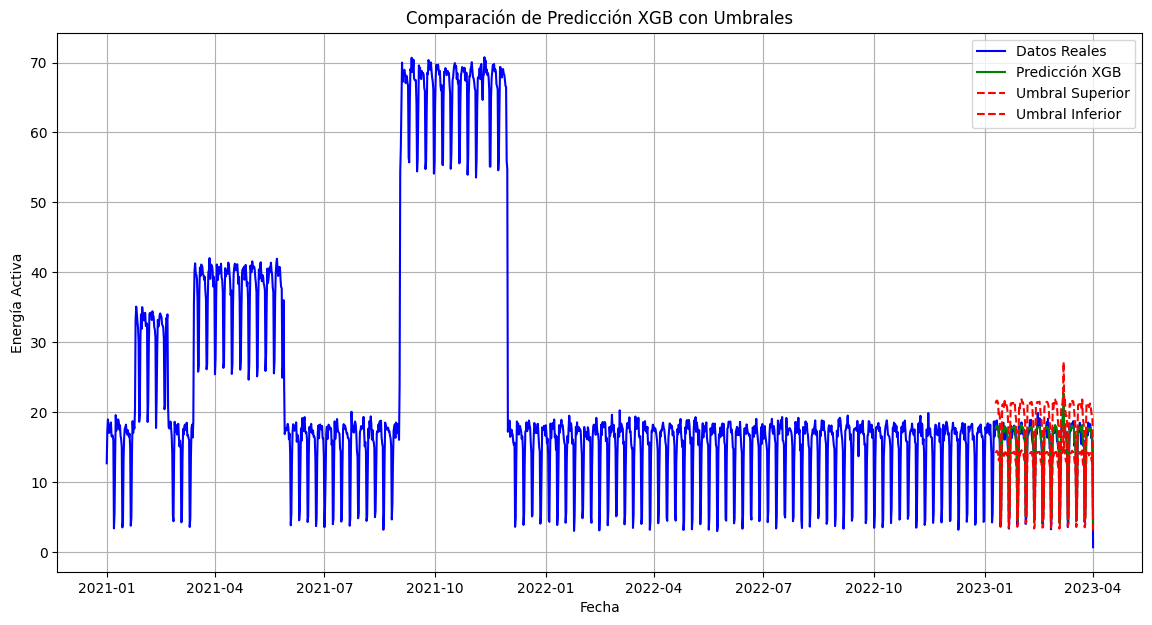

*************************************************
Cliente 2 - Cantidad pred 163
                   Fecha  Active_energy  Predictions    Cliente  Upper_Bound  \
1636 2023-03-30 00:00:00      29.977158    29.892384  Cliente 2    35.870861   
1637 2023-03-30 12:00:00      29.556087    28.895205  Cliente 2    34.674248   
1638 2023-03-31 00:00:00      29.783287    28.234179  Cliente 2    33.881016   
1639 2023-03-31 12:00:00      26.328793    27.794178  Cliente 2    33.353016   
1640 2023-04-01 00:00:00       1.885963    15.805664  Cliente 2    18.966797   

      Lower_Bound  anomalias  
1636    23.913908      False  
1637    23.116163      False  
1638    22.587343      False  
1639    22.235342      False  
1640    12.644531       True  


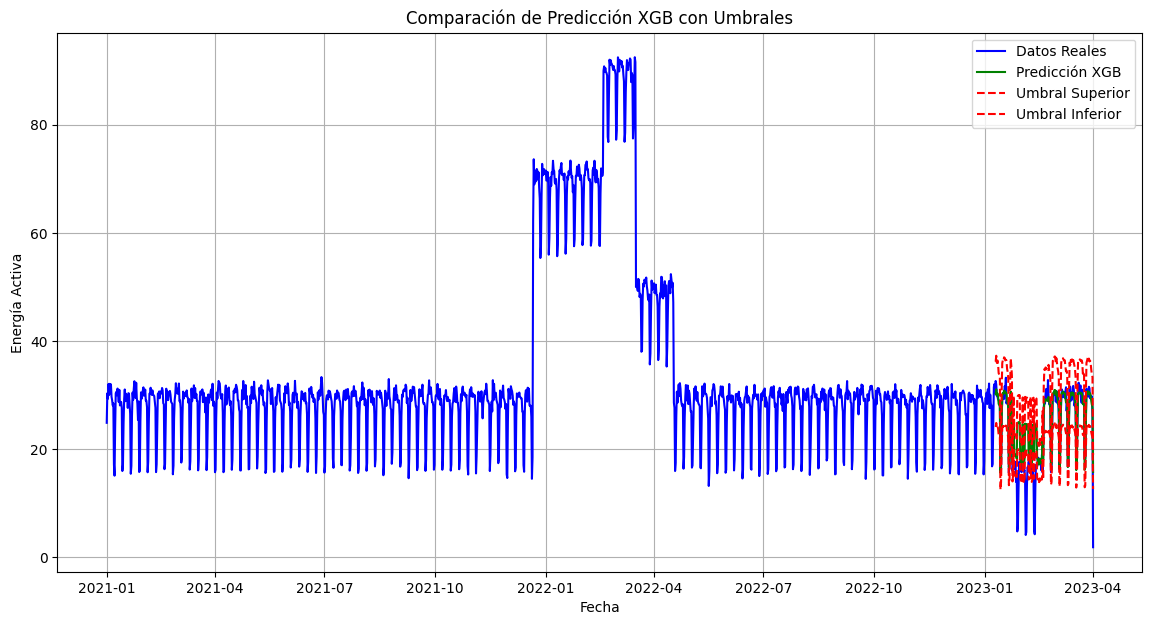

*************************************************
Cliente 3 - Cantidad pred 162
                   Fecha  Active_energy  Predictions    Cliente  Upper_Bound  \
1636 2023-03-30 00:00:00      22.877602    24.718174  Cliente 3    29.661810   
1637 2023-03-30 12:00:00      23.679724    24.113865  Cliente 3    28.936640   
1638 2023-03-31 00:00:00      24.037045    23.472980  Cliente 3    28.167578   
1639 2023-03-31 12:00:00      20.923873    23.210201  Cliente 3    27.852243   
1640 2023-04-01 00:00:00       1.780164    10.903612  Cliente 3    13.084335   

      Lower_Bound  anomalias  
1636    19.774540      False  
1637    19.291092      False  
1638    18.778385      False  
1639    18.568161      False  
1640     8.722890       True  


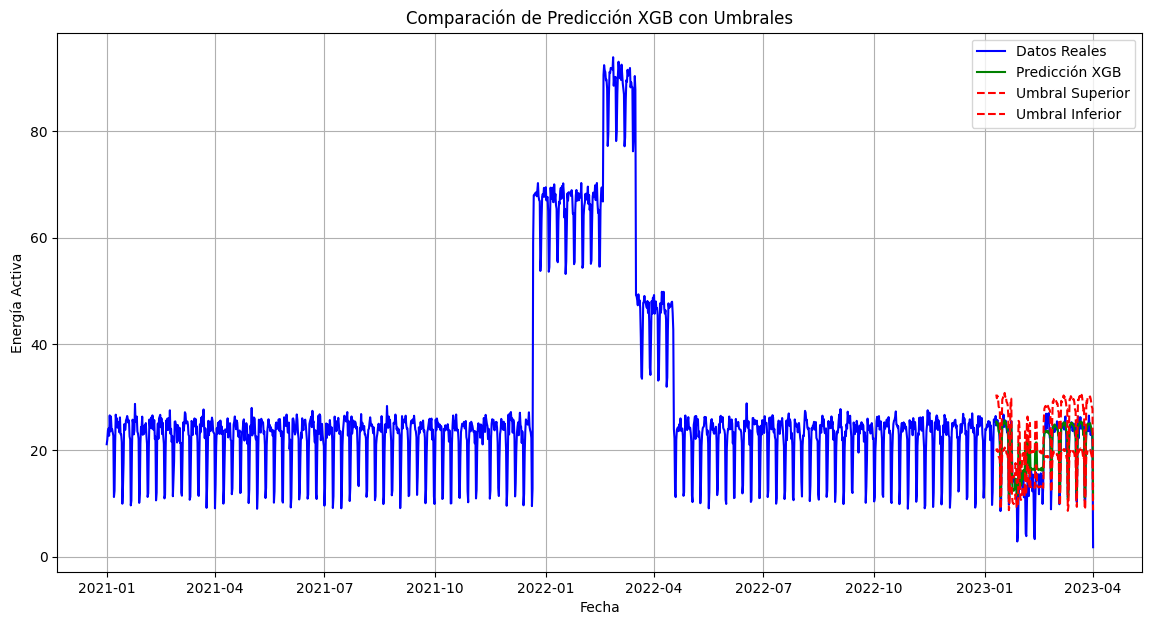

*************************************************
Cliente 9 - Cantidad pred 245
                   Fecha  Active_energy  Predictions    Cliente  Upper_Bound  \
2456 2023-03-30 16:00:00       1.697893     1.487462  Cliente 9     1.784954   
2457 2023-03-31 00:00:00       2.359728     2.582598  Cliente 9     3.099118   
2458 2023-03-31 08:00:00       1.635546     1.541112  Cliente 9     1.849334   
2459 2023-03-31 16:00:00       1.262551     1.543116  Cliente 9     1.851740   
2460 2023-04-01 00:00:00       0.116714     1.658454  Cliente 9     1.990145   

      Lower_Bound  anomalias  
2456     1.189970      False  
2457     2.066079      False  
2458     1.232889      False  
2459     1.234493      False  
2460     1.326763       True  


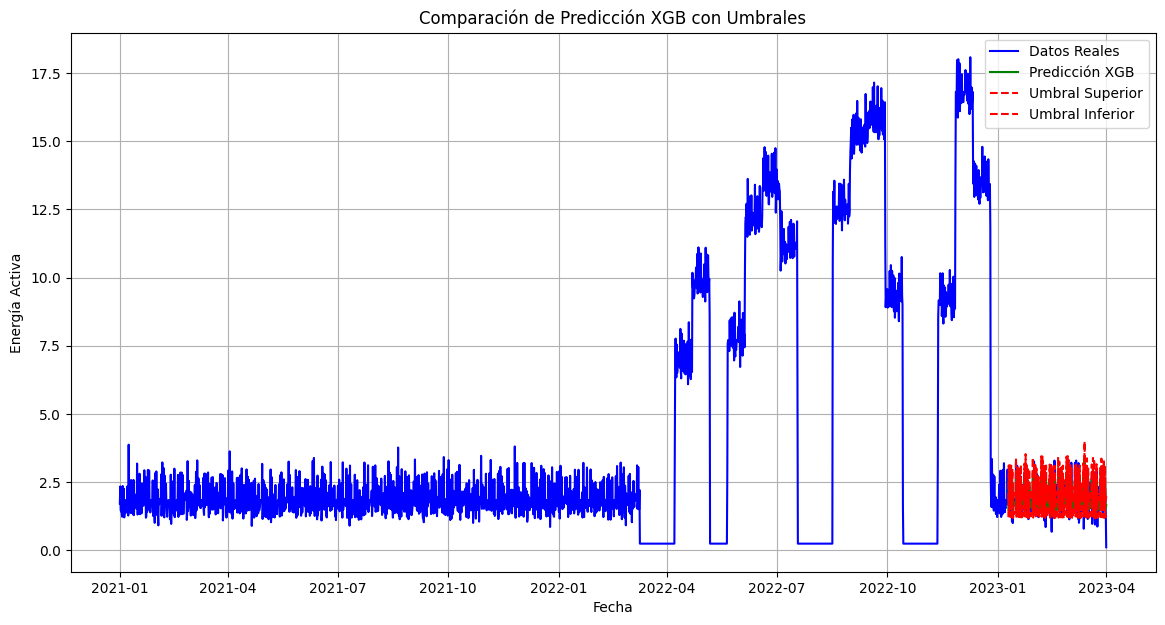

*************************************************
Cliente 12 - Cantidad pred 140
                   Fecha  Active_energy  Predictions     Cliente  Upper_Bound  \
1422 2022-04-20 00:00:00       6.375676     6.100311  Cliente 12     7.320373   
1423 2022-04-20 08:00:00       5.115871     6.097045  Cliente 12     7.316455   
1424 2022-04-20 16:00:00       5.358475     5.723066  Cliente 12     6.867679   
1425 2022-04-21 00:00:00       4.381716     5.823909  Cliente 12     6.988691   
1426 2022-04-21 08:00:00       6.782168     6.138007  Cliente 12     7.365608   

      Lower_Bound  anomalias  
1422     4.880249      False  
1423     4.877636      False  
1424     4.578453      False  
1425     4.659127       True  
1426     4.910406      False  


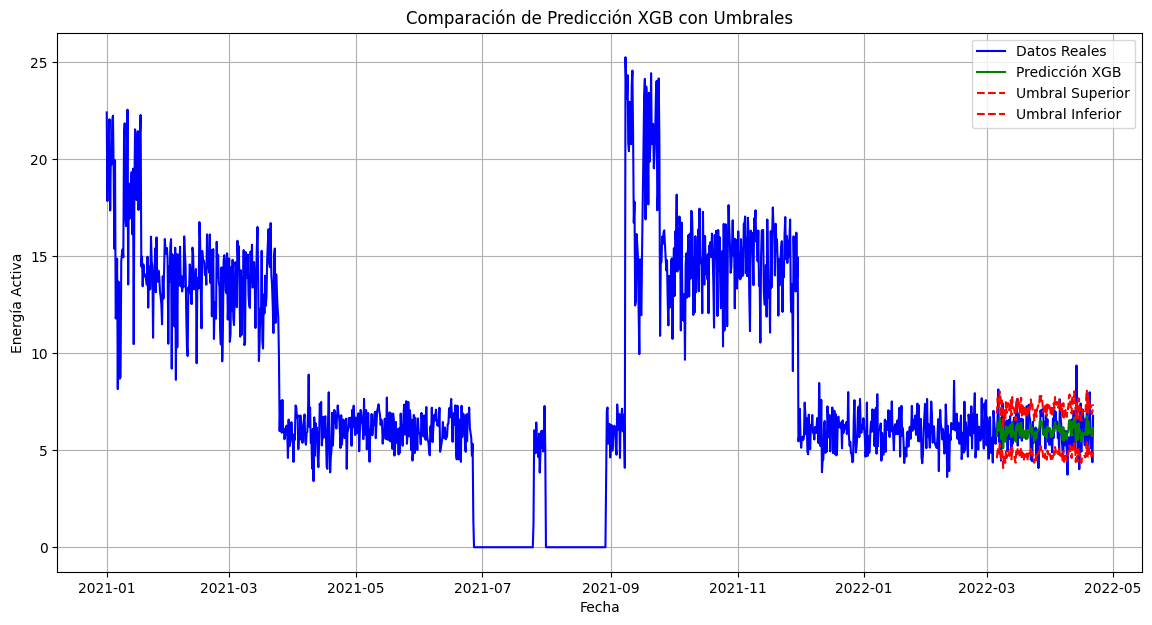

*************************************************
Cliente 20 - Cantidad pred 241
                   Fecha  Active_energy  Predictions     Cliente  Upper_Bound  \
2433 2023-03-23 00:00:00       4.502244     4.532716  Cliente 20     5.439259   
2434 2023-03-23 08:00:00       3.260294     3.255449  Cliente 20     3.906539   
2435 2023-03-23 16:00:00       3.061161     2.921045  Cliente 20     3.505254   
2436 2023-03-24 00:00:00       4.470733     4.494895  Cliente 20     5.393875   
2437 2023-03-24 08:00:00       1.961818     3.316190  Cliente 20     3.979428   

      Lower_Bound  anomalias  
2433     3.626173      False  
2434     2.604359      False  
2435     2.336836      False  
2436     3.595917      False  
2437     2.652952       True  


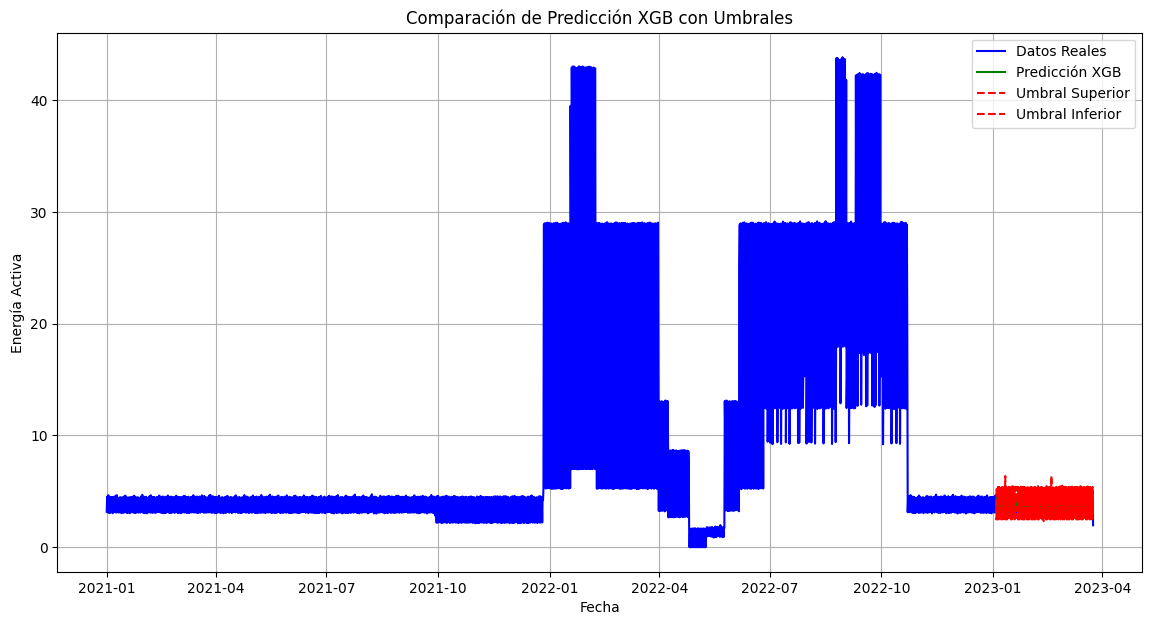

*************************************************
Cliente 21 - Cantidad pred 73
                  Fecha  Active_energy  Predictions     Cliente  Upper_Bound  \
739 2022-01-05 12:00:00       0.363351     0.413454  Cliente 21     0.496145   
740 2022-01-06 00:00:00       0.354189     0.771177  Cliente 21     0.925412   
741 2022-01-06 12:00:00       1.344287     1.355633  Cliente 21     1.626759   
742 2022-01-07 00:00:00       0.381815     0.450641  Cliente 21     0.540769   
743 2022-01-07 12:00:00       0.351907     0.368218  Cliente 21     0.441862   

     Lower_Bound  anomalias  
739     0.330763      False  
740     0.616941       True  
741     1.084506      False  
742     0.360513      False  
743     0.294575      False  


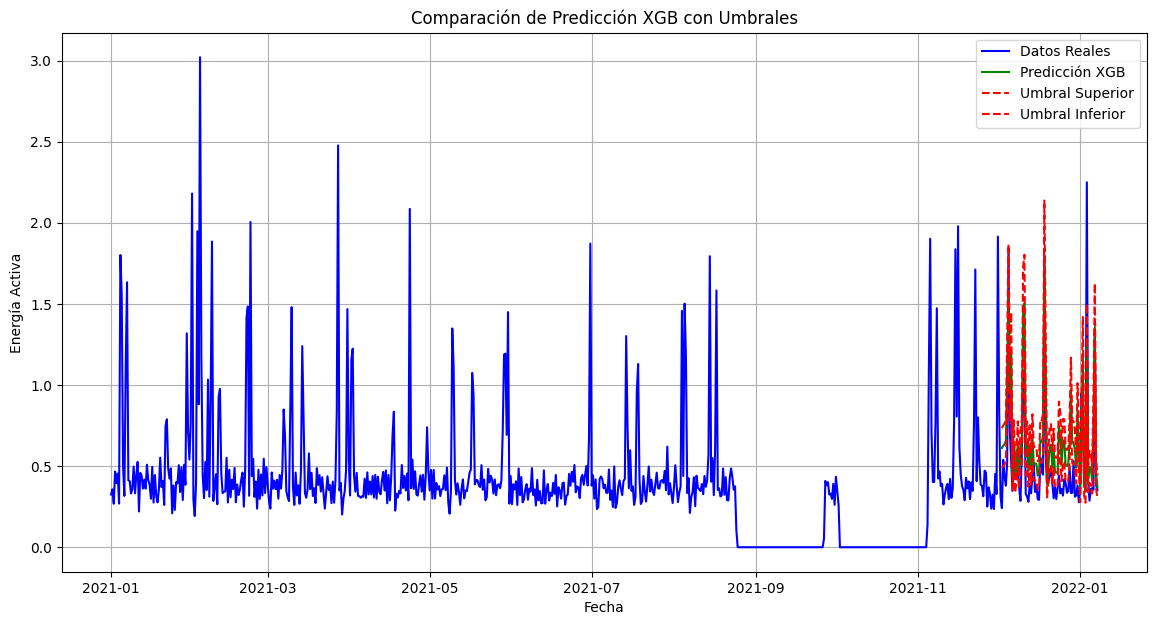

*************************************************
Cliente 22 - Cantidad pred 73
                  Fecha  Active_energy  Predictions     Cliente  Upper_Bound  \
739 2022-01-05 12:00:00       1.306335     1.540639  Cliente 22     1.848766   
740 2022-01-06 00:00:00       1.599281     1.557699  Cliente 22     1.869239   
741 2022-01-06 12:00:00       1.174604     1.584274  Cliente 22     1.901129   
742 2022-01-07 00:00:00       1.723999     1.577587  Cliente 22     1.893105   
743 2022-01-07 12:00:00       1.218799     1.544346  Cliente 22     1.853216   

     Lower_Bound  anomalias  
739     1.232511      False  
740     1.246159      False  
741     1.267419       True  
742     1.262070      False  
743     1.235477       True  


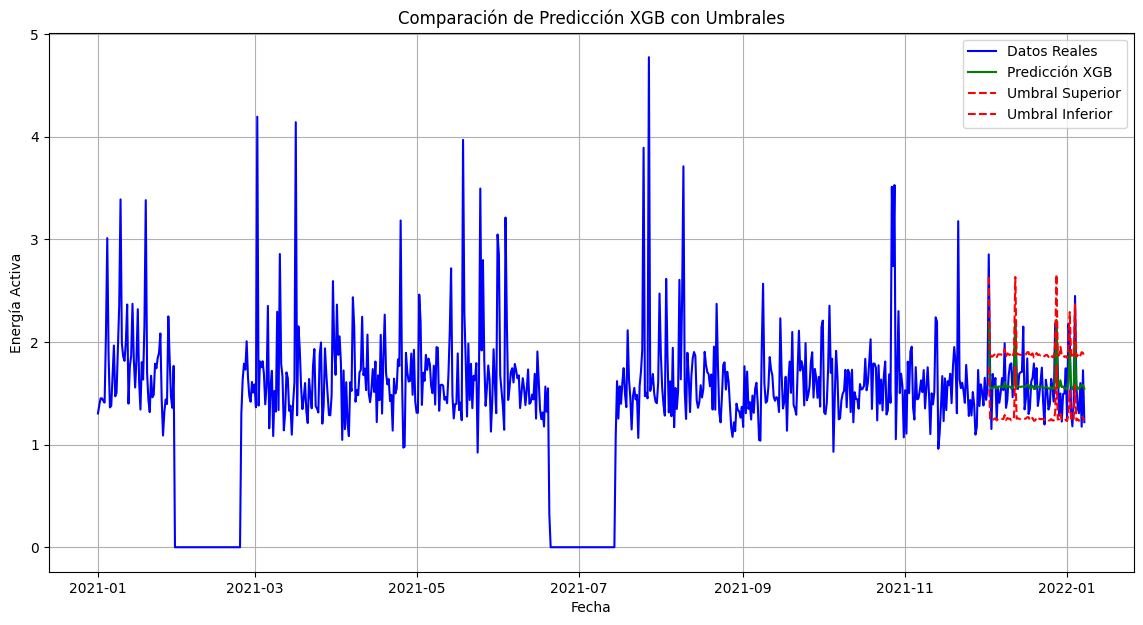

*************************************************
Cliente 23 - Cantidad pred 73
                  Fecha  Active_energy  Predictions     Cliente  Upper_Bound  \
739 2022-01-05 12:00:00       3.027015     2.877480  Cliente 23     3.452976   
740 2022-01-06 00:00:00       2.844741     2.800766  Cliente 23     3.360919   
741 2022-01-06 12:00:00       4.322894     3.106950  Cliente 23     3.728340   
742 2022-01-07 00:00:00       3.730097     2.782977  Cliente 23     3.339573   
743 2022-01-07 12:00:00       2.431254     2.599889  Cliente 23     3.119867   

     Lower_Bound  anomalias  
739     2.301984      False  
740     2.240613      False  
741     2.485560       True  
742     2.226382       True  
743     2.079911      False  


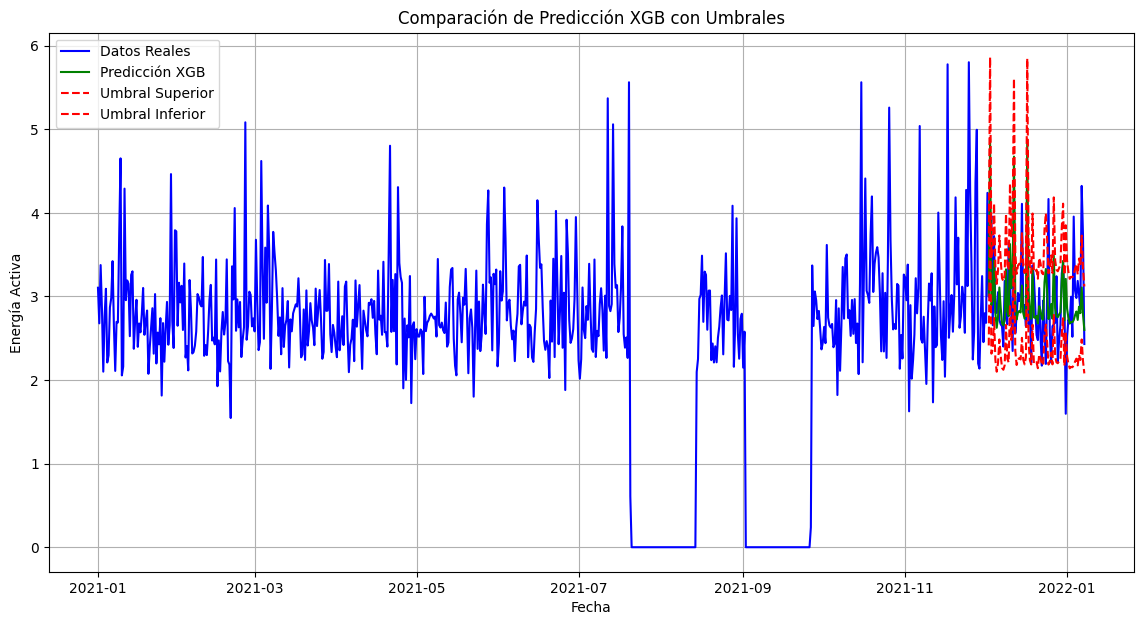

*************************************************
Cliente 24 - Cantidad pred 73
                  Fecha  Active_energy  Predictions     Cliente  Upper_Bound  \
739 2022-01-05 12:00:00       0.972091     0.842389  Cliente 24     1.010867   
740 2022-01-06 00:00:00       0.728360     0.802805  Cliente 24     0.963366   
741 2022-01-06 12:00:00       0.796875     0.825278  Cliente 24     0.990334   
742 2022-01-07 00:00:00       0.795849     0.893661  Cliente 24     1.072393   
743 2022-01-07 12:00:00       0.535383     0.796035  Cliente 24     0.955241   

     Lower_Bound  anomalias  
739     0.673911      False  
740     0.642244      False  
741     0.660223      False  
742     0.714928      False  
743     0.636828       True  


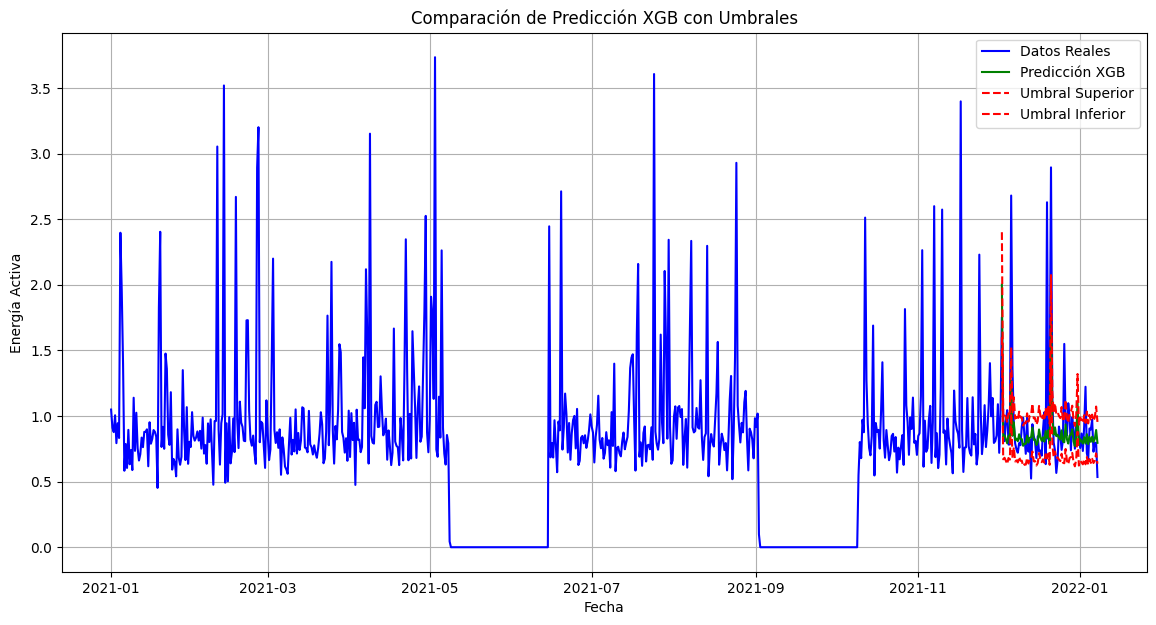

*************************************************
Cliente 25 - Cantidad pred 73
                  Fecha  Active_energy  Predictions     Cliente  Upper_Bound  \
739 2022-01-05 12:00:00       1.212225     1.292842  Cliente 25     1.551411   
740 2022-01-06 00:00:00       1.450788     1.239888  Cliente 25     1.487865   
741 2022-01-06 12:00:00       1.083473     1.373345  Cliente 25     1.648014   
742 2022-01-07 00:00:00       2.688309     1.327089  Cliente 25     1.592507   
743 2022-01-07 12:00:00       2.083291     1.303630  Cliente 25     1.564356   

     Lower_Bound  anomalias  
739     1.034274      False  
740     0.991910      False  
741     1.098676       True  
742     1.061671       True  
743     1.042904       True  


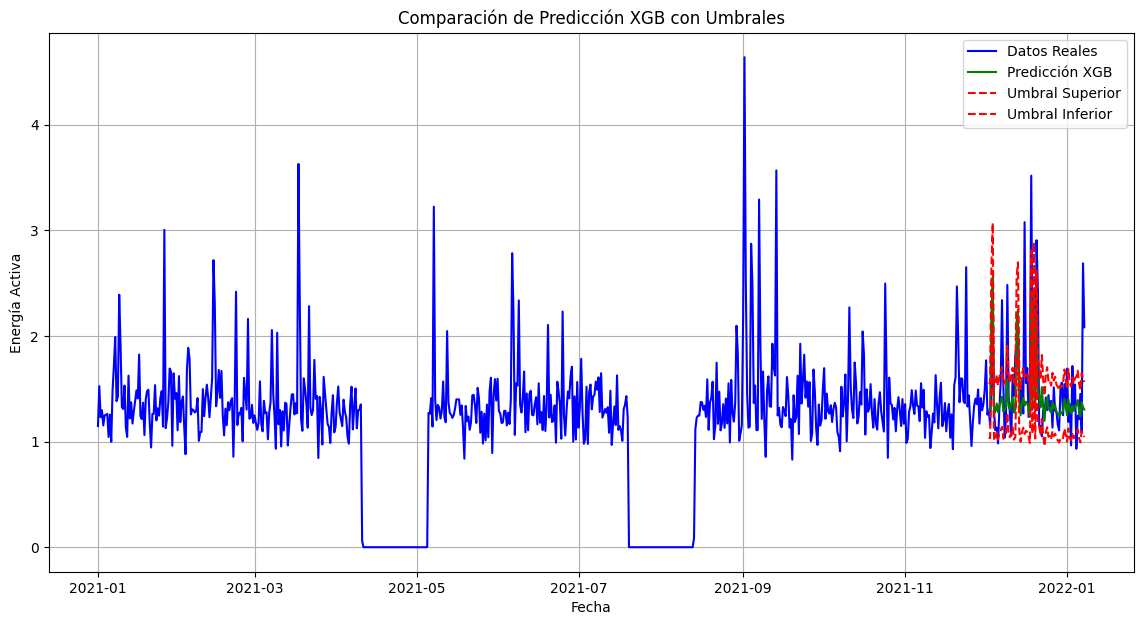

*************************************************
Cliente 26 - Cantidad pred 140
                   Fecha  Active_energy  Predictions     Cliente  Upper_Bound  \
1422 2022-04-20 00:00:00       6.193630     6.200362  Cliente 26     7.440435   
1423 2022-04-20 08:00:00       6.576128     6.111550  Cliente 26     7.333860   
1424 2022-04-20 16:00:00       6.135342     6.166852  Cliente 26     7.400222   
1425 2022-04-21 00:00:00       4.944402     5.251703  Cliente 26     6.302043   
1426 2022-04-21 08:00:00       5.554207     5.826847  Cliente 26     6.992216   

      Lower_Bound  anomalias  
1422     4.960290      False  
1423     4.889240      False  
1424     4.933481      False  
1425     4.201362      False  
1426     4.661478      False  


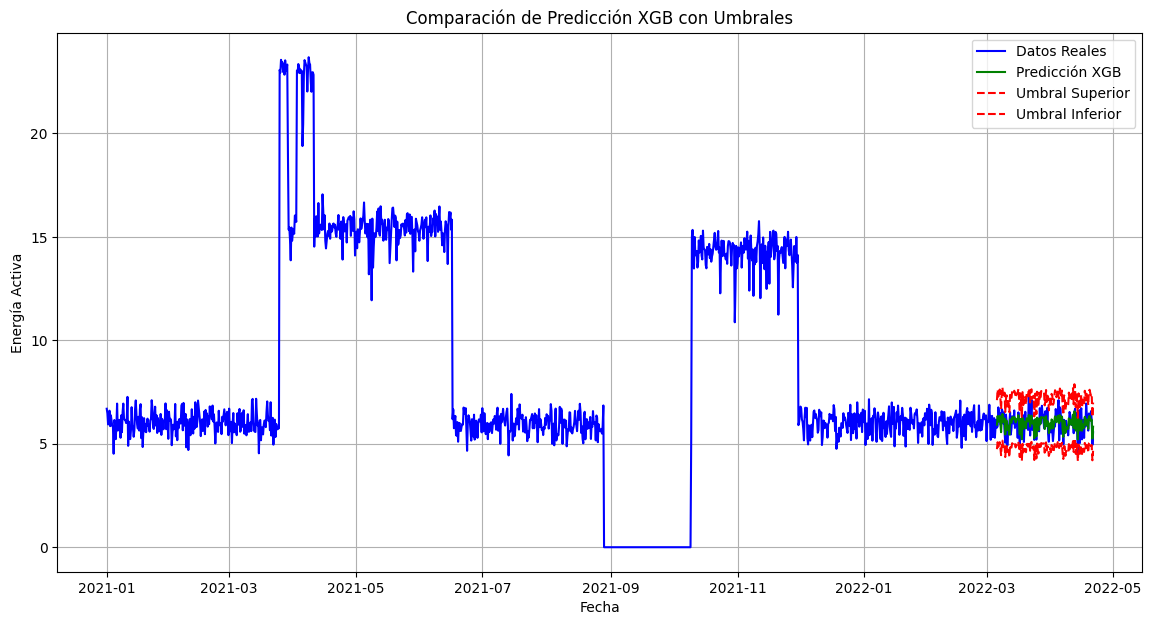

*************************************************
Cliente 27 - Cantidad pred 94
                  Fecha  Active_energy  Predictions     Cliente  Upper_Bound  \
947 2022-04-19 12:00:00      34.850890    33.368046  Cliente 27    40.041656   
948 2022-04-20 00:00:00      34.042897    33.547993  Cliente 27    40.257591   
949 2022-04-20 12:00:00      34.491630    33.256092  Cliente 27    39.907310   
950 2022-04-21 00:00:00      33.900993    33.224228  Cliente 27    39.869076   
951 2022-04-21 12:00:00       8.487720    26.344244  Cliente 27    31.613094   

     Lower_Bound  anomalias  
947    26.694437      False  
948    26.838394      False  
949    26.604874      False  
950    26.579382      False  
951    21.075396       True  


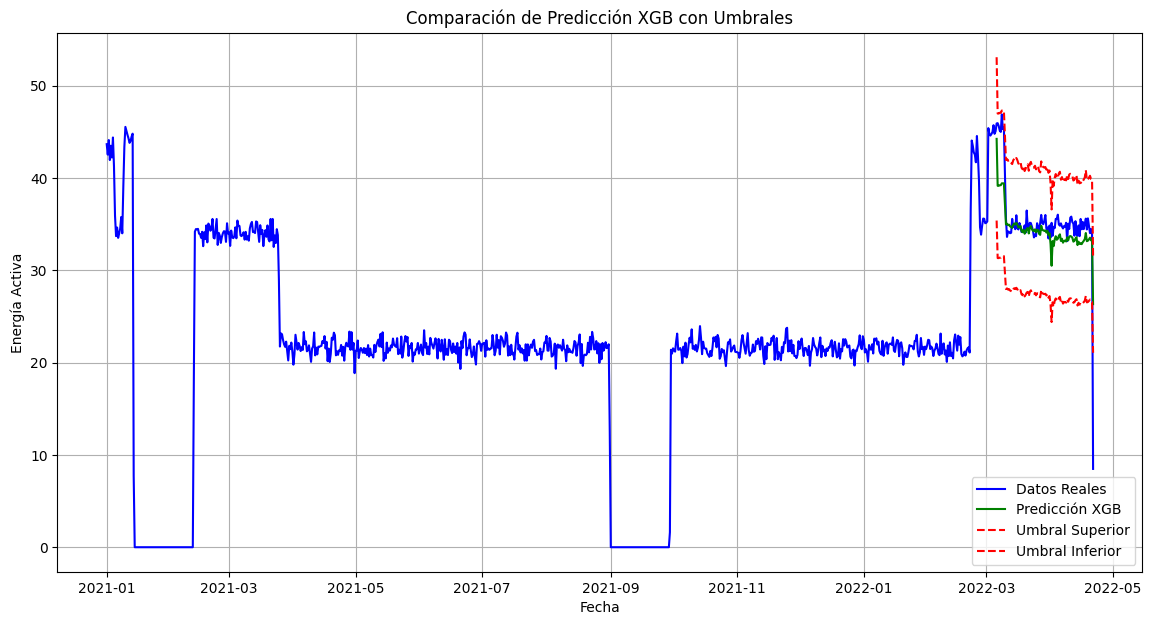

*************************************************
Cliente 28 - Cantidad pred 140
                   Fecha  Active_energy  Predictions     Cliente  Upper_Bound  \
1422 2022-04-20 00:00:00      11.101478    10.829610  Cliente 28    12.995532   
1423 2022-04-20 08:00:00      10.861974    10.662132  Cliente 28    12.794559   
1424 2022-04-20 16:00:00      10.579976    10.670747  Cliente 28    12.804896   
1425 2022-04-21 00:00:00      10.920932    10.554025  Cliente 28    12.664830   
1426 2022-04-21 08:00:00       8.916026    10.596862  Cliente 28    12.716235   

      Lower_Bound  anomalias  
1422     8.663688      False  
1423     8.529706      False  
1424     8.536597      False  
1425     8.443220      False  
1426     8.477489      False  


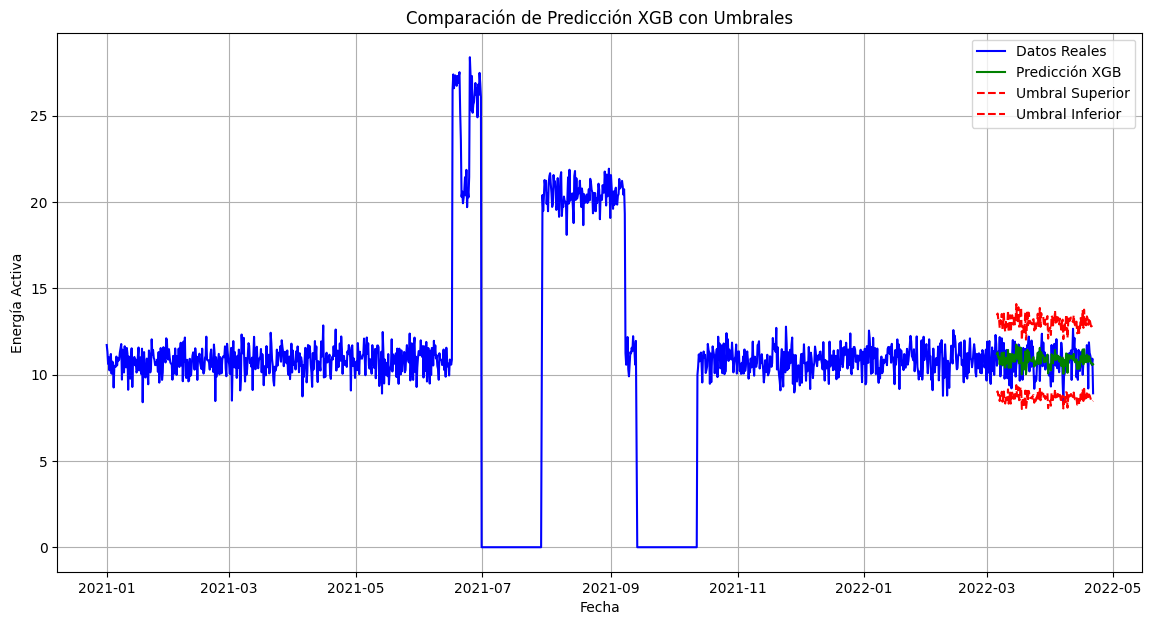

*************************************************
Cliente 29 - Cantidad pred 140
                   Fecha  Active_energy  Predictions     Cliente  Upper_Bound  \
1422 2022-04-20 00:00:00       2.500448     2.625388  Cliente 29     3.150465   
1423 2022-04-20 08:00:00       2.729804     2.868702  Cliente 29     3.442443   
1424 2022-04-20 16:00:00       1.930948     2.300033  Cliente 29     2.760039   
1425 2022-04-21 00:00:00       1.406550     1.785747  Cliente 29     2.142896   
1426 2022-04-21 08:00:00       2.399224     2.362429  Cliente 29     2.834915   

      Lower_Bound  anomalias  
1422     2.100310      False  
1423     2.294962      False  
1424     1.840026      False  
1425     1.428598       True  
1426     1.889943      False  


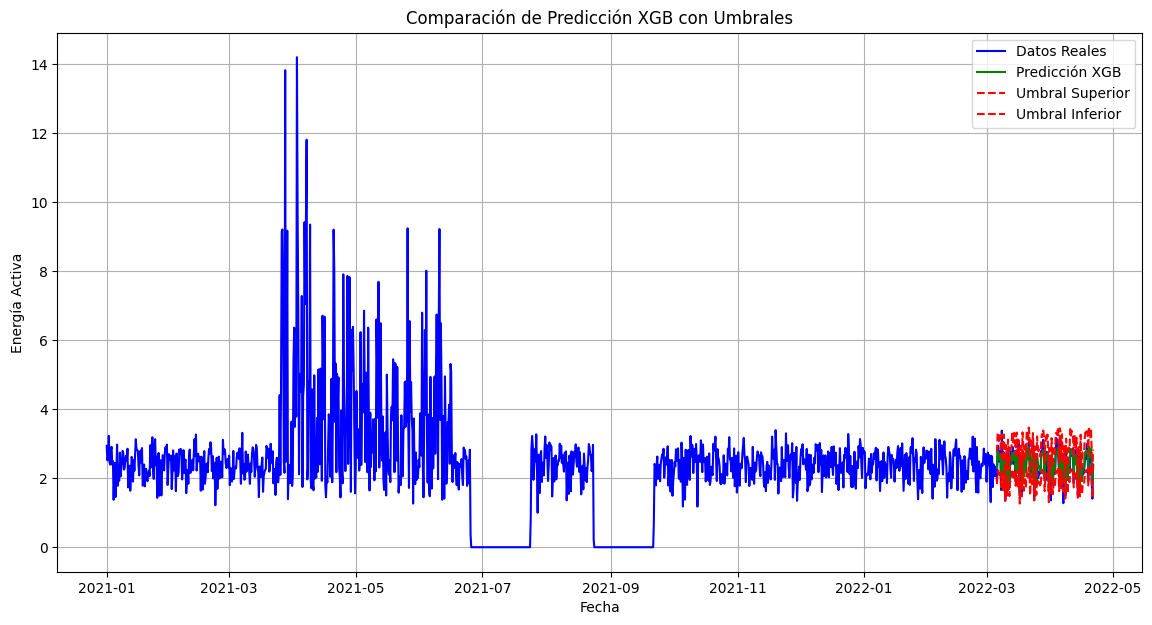

*************************************************
Cliente 30 - Cantidad pred 140
                   Fecha  Active_energy  Predictions     Cliente  Upper_Bound  \
1422 2022-04-20 00:00:00       6.375676     6.100311  Cliente 30     7.320373   
1423 2022-04-20 08:00:00       5.115871     6.097045  Cliente 30     7.316455   
1424 2022-04-20 16:00:00       5.358475     5.723066  Cliente 30     6.867679   
1425 2022-04-21 00:00:00       4.381716     5.823909  Cliente 30     6.988691   
1426 2022-04-21 08:00:00       6.782168     6.138007  Cliente 30     7.365608   

      Lower_Bound  anomalias  
1422     4.880249      False  
1423     4.877636      False  
1424     4.578453      False  
1425     4.659127       True  
1426     4.910406      False  


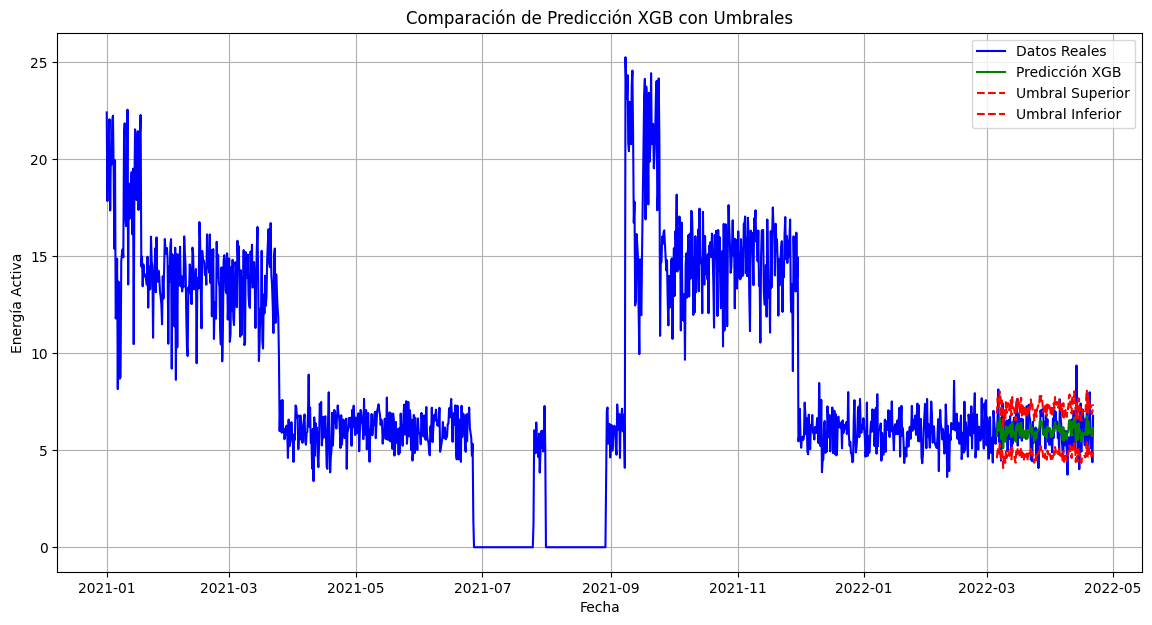

*************************************************


In [55]:
for pred_obj in predictions:
    
    prediction = pred_obj['prediction']
    cliente = pred_obj['cliente']
    rezago = pred_obj['rezago']
    data_completa_1 = pred_obj['data_completa']
   
    print(cliente, "- Cantidad pred",len(prediction))
        
    data_completa_1.reset_index(inplace=True)
    
    # Crear un DataFrame para los datos de predicciones
    df_predictions = pd.DataFrame({'Predictions': prediction})
    
    # Ajustar el índice de df_predictions para que comience después del último índice ocupado en data_completa_1
    start_index = data_completa_1.index.max() - len(prediction) + 1
    df_predictions.index = range(start_index, start_index + len(df_predictions))
    
    # Concatenar los datos de predicciones al final del DataFrame data_completa_1
    data_completa_1 = pd.concat([data_completa_1[['Fecha','Active_energy']], df_predictions], axis=1)
    
    # Agregar la columna Cliente
    data_completa_1['Cliente'] = cliente
    
    # Agregar las columnas Upper_Bound y Lower_Bound
    data_completa_1['Upper_Bound'] = data_completa_1['Predictions'] * (1 + 0.2)
    data_completa_1['Lower_Bound'] = data_completa_1['Predictions'] * (1 - 0.2)
    data_completa_1['anomalias'] = ((data_completa_1['Active_energy'] > data_completa_1['Upper_Bound']) |
                                (data_completa_1['Active_energy'] < data_completa_1['Lower_Bound']))
    
    print(data_completa_1.tail(5))


    plt.figure(figsize=(14, 7))
    plt.plot(data_completa_1['Fecha'], data_completa_1['Active_energy'], label='Datos Reales', color='blue') 
    plt.plot(data_completa_1['Fecha'], data_completa_1['Predictions'], label='Predicción XGB', color='green')
    plt.plot(data_completa_1['Fecha'], data_completa_1['Upper_Bound'], label='Umbral Superior', linestyle='--', color='red')
    plt.plot(data_completa_1['Fecha'], data_completa_1['Lower_Bound'], label='Umbral Inferior', linestyle='--', color='red')
    plt.title('Comparación de Predicción XGB con Umbrales')
    plt.xlabel('Fecha')
    plt.ylabel('Energía Activa')
    plt.legend()
    plt.grid(True)
    plt.show()

    
    # # Guardar el archivo.
    data_completa_1.to_excel('dashboard/data/'+cliente+'.xlsx')

    print('*************************************************')